In [17]:
#Carga de los primeros datasets claves
#Archivos involucrados siendo estos clientes, articulos, proveedores, compras, compras descuento y ventas items
import pandas as pd
import glob

# Ruta base
path = '../data/raw/'

# Cargar clientes, artículos, proveedores
df_clientes = pd.read_excel(path + 'clientes.xlsx')
df_articulos = pd.read_excel(path + 'articulos.xlsx')
df_proveedores = pd.read_excel(path + 'proveedores.xlsx')

# Cargar compras y ventas items
archivos_compras = glob.glob(path + 'compras_dcto_items_*.xlsx')
df_compras_items = pd.concat([pd.read_excel(f) for f in archivos_compras], ignore_index=True)

archivos_ventas = glob.glob(path + 'ventas_dcto_items_*.xlsx')
df_ventas_items = pd.concat([pd.read_excel(f) for f in archivos_ventas], ignore_index=True)


In [18]:
# Visualización tabular de los nombres de columnas y sus tipos
pd.DataFrame({
    'Variable': df_ventas_items.columns,
    'Tipo de Dato': df_ventas_items.dtypes.astype(str)
})



,Variable,Tipo de Dato
cod_cliente,cod_cliente,object
cliente,cliente,object
documento,documento,object
defecha,defecha,datetime64[ns]
cod_articulo_servicio,cod_articulo_servicio,object
nombre_articulo_servicio,nombre_articulo_servicio,object
cantidad,cantidad,float64
porc_iva,porc_iva,int64
vrgravado,vrgravado,float64
vrnogravado,vrnogravado,float64


In [83]:
#Visalizacion de datos nulos 
df_ventas_items.isnull().sum().sort_values(ascending=False)


cod_cliente                 450668
distrito                    332770
vendedor                       609
nomcuenta                        1
cuenta                           1
                             ...  
nombre_articulo_servicio         0
cod_articulo_servicio            0
defecha                          0
documento                        0
margen_pct                       0
Length: 24, dtype: int64

In [ ]:
#Identificar el porcentaje de datos nulos
df_ventas_items.isnull().mean().sort_values(ascending=False) * 100


cod_cliente                75.24
distrito                   55.56
vendedor                    0.10
nomcuenta                   0.00
cuenta                      0.00
                            ... 
nombre_articulo_servicio    0.00
cod_articulo_servicio       0.00
defecha                     0.00
documento                   0.00
margen_pct                  0.00
Length: 24, dtype: float64

In [ ]:
#dentificacion de valores unicos para identificar variables categoricas vs continuas
df_ventas_items.nunique().sort_values()


icolicoresunitario         1
distrito                   1
tipodocumento              2
porc_iva                   5
bodega                     8
                       ...  
subtotal               63346
costo                 101444
utilidadps            145693
margen_pct            147704
documento             195248
Length: 24, dtype: int64

In [87]:
#Revision de posibles outliers para campos como cantida, descuento, utilidad
df_ventas_items[['cantidad', 'descuento', 'utilidadps']].describe()


,cantidad,descuento,utilidadps
count,"598,989.00","598,989.00","598,989.00"
mean,4.04,143.98,"40,626.73"
std,20.78,"7,088.13","188,205.98"
min,0.00,0.00,"-1,278,814.81"
25%,1.00,0.00,"4,866.13"
50%,1.00,0.00,"10,853.41"
75%,2.21,0.00,"29,630.30"
max,"1,934.00","4,482,221.00","16,054,320.00"


In [89]:
#Numero de SKUs con exceso de inventarios
# Sumar ventas por SKU
ventas_por_sku = df_ventas_items.groupby('cod_articulo_servicio')['cantidad'].sum()

# Definir umbral de exceso arbitrario, por ejemplo, más de 500 unidades sin rotación
skus_exceso = ventas_por_sku[ventas_por_sku > 500]
print("SKUs con exceso de inventario:", len(skus_exceso))


SKUs con exceso de inventario: 346


In [101]:
# 1. Calcular ingreso total por cliente
ventas_por_cliente = df_ventas_items.groupby('cod_cliente')['subtotal'].sum().reset_index()
ventas_por_cliente.columns = ['cod_cliente', 'total_vendido']

# 2. Ordenar por total vendido de mayor a menor
ventas_por_cliente = ventas_por_cliente.sort_values(by='total_vendido', ascending=False).reset_index(drop=True)

# 3. Calcular porcentaje de contribución e ingreso acumulado
ventas_por_cliente['porcentaje'] = ventas_por_cliente['total_vendido'] / ventas_por_cliente['total_vendido'].sum()
ventas_por_cliente['porcentaje_acumulado'] = ventas_por_cliente['porcentaje'].cumsum()

# 4. Identificar cuántos clientes generan el 80% del ingreso
clientes_top_80 = ventas_por_cliente[ventas_por_cliente['porcentaje_acumulado'] <= 0.80]

# 5. Calcular el % de clientes que representan ese 80%
n_top = clientes_top_80.shape[0]
n_total = ventas_por_cliente.shape[0]
porcentaje_clientes = (n_top / n_total) * 100

print(f"{n_top} clientes generan el 80% del ingreso, lo que equivale al {porcentaje_clientes:.2f}% del total de clientes")


27 clientes generan el 80% del ingreso, lo que equivale al 4.37% del total de clientes


In [90]:
#Clientes unicos que han comprado estos SKUs con exceso 
clientes_potenciales = df_ventas_items[df_ventas_items['cod_articulo_servicio'].isin(skus_exceso.index)]
clientes_unicos = clientes_potenciales['cod_cliente'].nunique()
print("Clientes potenciales únicos:", clientes_unicos)


Clientes potenciales únicos: 609


In [91]:
#SKU con mas exceso
sku_mas_exceso = ventas_por_sku.idxmax()
print("Top SKU con más exceso:", sku_mas_exceso)


Top SKU con más exceso:           101039


In [103]:
productos = df_ventas_items.groupby('nombre_articulo_servicio')[['cantidad', 'utilidadpc']].sum().reset_index()
productos = productos.sort_values(by='cantidad', ascending=False).reset_index(drop=True)


In [105]:
productos['pct_cantidad'] = productos['cantidad'] / productos['cantidad'].sum()
productos['pct_utilidad'] = productos['utilidadpc'] / productos['utilidadpc'].sum()

productos['acum_cantidad'] = productos['pct_cantidad'].cumsum()
productos['acum_utilidad'] = productos['pct_utilidad'].cumsum()


In [107]:
top3 = productos.head(3)

print("Contribución top 3 productos:")
print(f"Volumen: {top3['cantidad'].sum() / productos['cantidad'].sum() * 100:.1f}%")
print(f"Margen: {top3['utilidadpc'].sum() / productos['utilidadpc'].sum() * 100:.1f}%")


Contribución top 3 productos:
Volumen: 17.1%
Margen: 0.7%


In [92]:
#SKUS con mas clientes historicos 
clientes_por_sku = df_ventas_items.groupby('cod_articulo_servicio')['cod_cliente'].nunique()
sku_mas_clientes = clientes_por_sku.idxmax()
print("Top SKU con más clientes únicos:", sku_mas_clientes)


Top SKU con más clientes únicos:           101039


In [62]:
# Obtener costo promedio por SKU desde el dataset de ventas
costo_unitario = df_ventas_items.groupby('cod_articulo_servicio')['costo'].mean().reset_index()

# Unir el costo unitario al dataframe de exceso
exceso_con_costo = exceso_stock.merge(costo_unitario, on='cod_articulo_servicio', how='left')

# Calcular el costo inmovilizado por sobrestock
exceso_con_costo['costo_inmovilizado'] = exceso_con_costo['exceso'] * exceso_con_costo['costo']

# Mostrar el top 5 productos con mayor costo inmovilizado
top_costo_inmovilizado = exceso_con_costo.sort_values(by='costo_inmovilizado', ascending=False).head(5)
display(top_costo_inmovilizado)


,cod_articulo_servicio,cantidad_comprada,cantidad_vendida,exceso,costo,costo_inmovilizado
308,101039,"337,104.00","173,026.00","164,078.00","225,898.04","37,064,898,171.69"
315,101055,"300,648.00","152,796.00","147,852.00","222,624.48","32,915,474,875.66"
312,101052,"164,856.00","78,277.00","86,579.00","197,731.27","17,119,375,194.05"
321,101062,"99,600.00","42,976.00","56,624.00","132,676.92","7,512,697,963.62"
317,101057,"104,400.00","47,012.00","57,388.00","124,950.45","7,170,656,279.41"


In [73]:
# Asegurarse que la columna de fechas esté en formato datetime
df_ventas_items['defecha'] = pd.to_datetime(df_ventas_items['defecha'])

# Ordenar por cliente y fecha de compra
df_ventas_items_sorted = df_ventas_items.sort_values(by=['cod_cliente', 'defecha'])

# Calcular la diferencia de días entre compras consecutivas por cliente
df_ventas_items_sorted['dias_entre_compras'] = df_ventas_items_sorted.groupby('cod_cliente')['defecha'].diff().dt.days

# Calcular la frecuencia promedio de recompra (ignorando NaNs de la primera compra de cada cliente)
frecuencia_promedio_recompra = df_ventas_items_sorted['dias_entre_compras'].mean()

print(f"Frecuencia promedio de recompra: {frecuencia_promedio_recompra:.2f} días")


Frecuencia promedio de recompra: 2.16 días


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_2042/724643216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_items['defecha'] = pd.to_datetime(df_ventas_items['defecha'])


In [74]:
top_skus = (
    df_ventas_items
    .groupby('cod_articulo_servicio')['cantidad']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)


In [75]:
compras_top = df_compras_items[df_compras_items['cod_articulo_servicio'].isin(top_skus)].copy()
ventas_top = df_ventas_items[df_ventas_items['cod_articulo_servicio'].isin(top_skus)].copy()

# Asegurar formato datetime
compras_top['defecha'] = pd.to_datetime(compras_top['defecha'])
ventas_top['defecha'] = pd.to_datetime(ventas_top['defecha'])


In [76]:
from tqdm import tqdm

# Crear estructura para guardar resultados
resultados = []

for sku in tqdm(top_skus):
    df_compras = compras_top[compras_top['cod_articulo_servicio'] == sku].sort_values('defecha')
    df_ventas = ventas_top[ventas_top['cod_articulo_servicio'] == sku].sort_values('defecha')
    
    diferencias = []
    for venta_fecha in df_ventas['defecha']:
        fechas_anteriores = df_compras[df_compras['defecha'] <= venta_fecha]
        if not fechas_anteriores.empty:
            compra_mas_reciente = fechas_anteriores['defecha'].max()
            delta_dias = (venta_fecha - compra_mas_reciente).days
            diferencias.append(delta_dias)

    if diferencias:
        promedio_dias = sum(diferencias) / len(diferencias)
        resultados.append({'cod_articulo_servicio': sku, 'dias_promedio': promedio_dias})


100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


In [77]:
df_resultados = pd.DataFrame(resultados).sort_values(by='dias_promedio', ascending=False)
display(df_resultados)


,cod_articulo_servicio,dias_promedio
3,101056,72.72
5,101057,66.29
7,101062,59.48
8,101053,53.95
2,101052,50.74
4,159005,45.06
6,150174,44.76
1,101055,42.72
0,101039,41.11


In [70]:
import pandas as pd

# Asegurarse de que 'defecha' sea tipo datetime y crear columna 'mes'
df_ventas_items.loc[:, 'defecha'] = pd.to_datetime(df_ventas_items['defecha'])
df_ventas_items.loc[:, 'mes'] = df_ventas_items['defecha'].dt.to_period('M').dt.to_timestamp()

# Agrupar por SKU y mes para obtener cantidad mensual vendida
ventas_mensual = (
    df_ventas_items
    .groupby(['cod_articulo_servicio', 'mes'])['cantidad']
    .sum()
    .reset_index()
)

# Calcular coeficiente de variación (CV) por SKU
cv_por_sku = (
    ventas_mensual
    .groupby('cod_articulo_servicio')['cantidad']
    .agg(['mean', 'std'])
    .reset_index()
)

cv_por_sku['cv'] = cv_por_sku['std'] / cv_por_sku['mean']

# Unir con los nombres de los productos
sku_nombres = df_ventas_items[['cod_articulo_servicio', 'nombre_articulo_servicio']].drop_duplicates()
skus_mas_volatiles = cv_por_sku.merge(sku_nombres, on='cod_articulo_servicio', how='left')

# Ordenar por mayor volatilidad
skus_mas_volatiles = skus_mas_volatiles.sort_values(by='cv', ascending=False)

# Mostrar el top 10 más volátiles
display(skus_mas_volatiles[['cod_articulo_servicio', 'nombre_articulo_servicio', 'cv']].head(10))



,cod_articulo_servicio,nombre_articulo_servicio,cv
389,120254,CDV. LIVANA CARMENERE X 750 ML,4.36
1314,122454,LF. CHORIZO IBERICO BELLOTA X 100,3.41
1320,122460,LF. SALAMI FINAS HIERBAS X 100,3.10
181,100722,CAJA REGALO CAVA DE QUESOS,2.98
66,100267,CDV. LFE CARMENERE X 750,2.95
1454,122607,DLK. ZUCCARDI RESERVA MALBEC 750,2.82
143,100502,GWS. CASILLERO DIABLO DARK RED X 750,2.79
471,120611,CAJA CAVA DE QUESO GRANDE,2.77
2295,160104,MOR. GALLETA ROYAL DANSK X 125 GR,2.66
396,120262,CDV. COMENGE BIBERIUS,2.65


In [71]:
# Contar la cantidad de SKUs con volatilidad calculada (cv no nulo y mayor a 0)
cantidad_skus_volatiles = skus_mas_volatiles[skus_mas_volatiles['cv'].notnull() & (skus_mas_volatiles['cv'] > 0)]['cod_articulo_servicio'].nunique()

print(f"Cantidad total de SKUs con volatilidad en ventas: {cantidad_skus_volatiles}")


Cantidad total de SKUs con volatilidad en ventas: 1945


In [100]:
clientes_top_80 = df_enriquecido[df_enriquecido['porcentaje_acumulado'] <= 0.80]
print(clientes_top_80.shape[0])     # n_top = 31
print(df_enriquecido.shape[0])      # n_total = 713


31
713


In [68]:
# Filtrar costos no válidos
df_ventas_items = df_ventas_items[df_ventas_items['costo'] > 0]

# Preparar datos mensuales
df_ventas_items['mes'] = pd.to_datetime(df_ventas_items['defecha']).dt.to_period('M').dt.to_timestamp()
costo_mensual = (
    df_ventas_items
    .groupby(['cod_articulo_servicio', 'mes'])['costo']
    .mean()
    .reset_index()
)

# Definir tendencia creciente
def es_tendencia_ascendente(grupo):
    return (grupo['costo'].nunique() > 1) and grupo['costo'].is_monotonic_increasing

# Filtrar SKUs
skus_costo_en_aumento = (
    costo_mensual
    .groupby('cod_articulo_servicio')
    .filter(es_tendencia_ascendente)
)

# Mostrar resultados
print(f"Total de SKUs con costo promedio en aumento: {skus_costo_en_aumento['cod_articulo_servicio'].nunique()}")
display(skus_costo_en_aumento.sort_values(['cod_articulo_servicio', 'mes']))


Total de SKUs con costo promedio en aumento: 153


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_2042/3345851956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_items['mes'] = pd.to_datetime(df_ventas_items['defecha']).dt.to_period('M').dt.to_timestamp()


,cod_articulo_servicio,mes,costo
710,100164,2023-01-01,"65,268.00"
711,100164,2023-12-01,"755,700.00"
712,100164,2024-11-01,"755,700.00"
793,100189,2023-10-01,"3,865.55"
794,100189,2023-11-01,"3,865.55"
...,...,...,...
28895,152028,2022-01-01,"1,221.75"
28896,152028,2022-02-01,"1,221.76"
28897,152028,2022-03-01,"1,221.76"
28898,152028,2022-05-01,"1,221.76"


In [78]:
tiempo_promedio_top10 = df_resultados['dias_promedio'].mean()
print(f"Tiempo promedio entre compra y venta (Top 10 SKUs): {tiempo_promedio_top10:.2f} días")


Tiempo promedio entre compra y venta (Top 10 SKUs): 52.98 días


In [79]:
# Evita dividir por cero
df_ventas_items['margen_pct'] = df_ventas_items['utilidadpc'] / df_ventas_items['costo'].replace(0, pd.NA)
skus_bajo_margen = df_ventas_items[df_ventas_items['margen_pct'] < 0.10]['cod_articulo_servicio'].nunique()
skus_totales = df_ventas_items['cod_articulo_servicio'].nunique()
porcentaje_bajo_margen = 100 * skus_bajo_margen / skus_totales
print(f"SKUs con margen bajo: {porcentaje_bajo_margen:.2f}%")


SKUs con margen bajo: 98.93%


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_2042/3458717849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ventas_items['margen_pct'] = df_ventas_items['utilidadpc'] / df_ventas_items['costo'].replace(0, pd.NA)


In [80]:
top_producto = df_ventas_items.groupby(['cod_articulo_servicio', 'nombre_articulo_servicio'])['cantidad'].sum().sort_values(ascending=False).head(1)
print(f"Producto más vendido: {top_producto}")


Producto más vendido: cod_articulo_servicio  nombre_articulo_servicio        
101039                 MERMEL 4 FRUTAS ST DALF X 284 GR   177,663.00
Name: cantidad, dtype: float64


In [81]:
clientes_unicos = df_ventas_items['cod_cliente'].nunique()
print(f"Clientes únicos: {clientes_unicos}")


Clientes únicos: 618


In [82]:
# Agrupar la cantidad total vendida por SKU
rotacion_por_sku = df_ventas_items.groupby('cod_articulo_servicio')['cantidad'].sum()

# Calcular la rotación promedio general
rotacion_promedio_general = rotacion_por_sku.mean()

# Mostrar el resultado
print(f"Rotación promedio general por SKU: {rotacion_promedio_general:.2f} unidades")


Rotación promedio general por SKU: 1040.53 unidades


In [65]:
# Detectar SKUs no rentables (utilidad negativa acumulada)

# Agrupar por SKU y sumar la utilidad
skus_no_rentables = (
    df_ventas_items
    .groupby(['cod_articulo_servicio', 'nombre_articulo_servicio'])['utilidadpc']
    .sum()
    .reset_index(name='utilidad_total')
)

# Filtrar los SKUs con utilidad total negativa
skus_no_rentables = skus_no_rentables[skus_no_rentables['utilidad_total'] < 0]

# Mostrar resultados
print(f"Total de SKUs no rentables: {len(skus_no_rentables)}")
display(skus_no_rentables.sort_values(by='utilidad_total'))  # Ordenados de más a menos pérdida


Total de SKUs no rentables: 26


,cod_articulo_servicio,nombre_articulo_servicio,utilidad_total
2027,122811,ALM.INV. ACQUA PANNA PET 500 ML,"-82,699.79"
2030,122814,ALM.INV. AGUA SAN PELLEGRINO PET X 500,"-68,112.46"
528,100722,CAJA REGALO CAVA DE QUESOS,"-54,027.61"
1399,122047,MO—O,"-51,428.42"
2029,122813,ALM.INV. AGUA SAN PELLEGRINO 750 ML,"-18,804.51"
...,...,...,...
2731,160215,BOLSAS GRANDE NEGRA THE WINE CELLAR,-30.34
1314,121937,A.O.C EXTRA MINIATURA X15 ML 5 ELEMENTOS,-15.23
558,100813,ARLA FETA ACEITUNAS X 3 UND,-8.60
2054,122854,ALM.INV. UGALDE BLANCO 750,-7.05


In [66]:
# Calcular la frecuencia de compra por cliente (número de compras realizadas)
frecuencia_clientes = df_ventas_items.groupby('cod_cliente')['documento'].nunique().reset_index(name='frecuencia_compras')

# Filtrar clientes con baja frecuencia (por ejemplo, <= 2 compras)
clientes_baja_frecuencia = frecuencia_clientes[frecuencia_clientes['frecuencia_compras'] <= 2]

# Mostrar la cantidad total de clientes con baja frecuencia
print(f"Cantidad de clientes con baja frecuencia: {len(clientes_baja_frecuencia)}")

# Opcional: mostrar listado
display(clientes_baja_frecuencia.sort_values(by='frecuencia_compras'))


Cantidad de clientes con baja frecuencia: 240


,cod_cliente,frecuencia_compras
3,CL 10024,1
515,CL 100000001796,1
516,CL 100000001797,1
536,CL 100000001818,1
544,CL 100000001826,1
...,...,...
545,CL 100000001828,2
257,CL 100000001275,2
535,CL 100000001817,2
366,CL 100000001596,2


In [63]:
costo_total_inmovilizado = exceso_con_costo['costo_inmovilizado'].sum()
print(f"Costo Inmovilizado Total: ${costo_total_inmovilizado:,.0f} COP")


Costo Inmovilizado Total: $220,792,354,005 COP


In [41]:
#Revenue total
revenue_total = df_ventas_items['subtotal'].sum()
print(f"Ingresos totales: ${revenue_total:,.0f}")


Ingresos totales: $54,119,440,265


In [ ]:
#Costo total generado
costo_total = df_ventas_items['costo'].sum()
print(f"Costo total: ${costo_total:,.0f}")


Costo total: $29,571,309,385


In [43]:
#Utilidad Bruta Total
utilidad_bruta = revenue_total - costo_total
print(f"Utilidad bruta: ${utilidad_bruta:,.0f}")


Utilidad bruta: $24,548,130,880


In [44]:
#Promedio de margen por producto
margen_promedio = df_ventas_items['utilidadpc'].mean()
print(f"Margen promedio por producto: ${margen_promedio:,.2f}")


Margen promedio por producto: $351.22


In [45]:
#Top Clientes por Ingreso
top_clientes = df_ventas_items.groupby('cliente')['subtotal'].sum().sort_values(ascending=False).head(10)
print(top_clientes)


cliente
CENCOSUD COLOMBIA S.A.        1.331342e+10
VENTA MOSTRADOR - P.O.S.      1.237009e+10
ALMACENES EXITO S A           4.427674e+09
SUPERTIENDAS CA—AVERAL SAS    2.549564e+09
INVERSIONES EURO S. A.        1.691803e+09
AMORE GROUP S.A.S.            1.336240e+09
SUPER A LIMITADA              1.209148e+09
DLK S.A.S.                    9.481164e+08
MERA EL DORADO S.A.S.         8.105992e+08
NEGOCIOS LA PLAZA SAS         7.448208e+08
Name: subtotal, dtype: float64


In [46]:
#Rotacion Total por SKU 
rotacion_sku = df_ventas_items.groupby('cod_articulo_servicio')['cantidad'].sum()


In [59]:
# Calcular desviación estándar de rotación por producto (SKU)
variabilidad_rotacion = (
    df_ventas_items.groupby('cod_articulo_servicio')['cantidad']
    .std()
    .reset_index(name='desviacion_rotacion')
    .sort_values(by='desviacion_rotacion', ascending=False)
)

display(variabilidad_rotacion.head(10))  # Top 10 productos más variables


,cod_articulo_servicio,desviacion_rotacion
307,158998,848.53
1901,122646,178.44
666,101039,111.25
673,101055,101.32
193,121253,91.54
670,101052,84.04
174,120971,71.13
2614,123494,68.79
692,101077,65.32
693,101078,64.29


In [60]:
#Deteccion de productos con sobrestock acumulado
# Agrupar compras y ventas por SKU
compras = df_compras_items.groupby('cod_articulo_servicio')['cantidad'].sum().reset_index(name='cantidad_comprada')
ventas = df_ventas_items.groupby('cod_articulo_servicio')['cantidad'].sum().reset_index(name='cantidad_vendida')

# Unir y calcular exceso de inventario
exceso_stock = compras.merge(ventas, on='cod_articulo_servicio', how='left')
exceso_stock['cantidad_vendida'] = exceso_stock['cantidad_vendida'].fillna(0)
exceso_stock['exceso'] = exceso_stock['cantidad_comprada'] - exceso_stock['cantidad_vendida']

top_exceso = exceso_stock.sort_values(by='exceso', ascending=False).head(10)
display(top_exceso)


,cod_articulo_servicio,cantidad_comprada,cantidad_vendida,exceso
308,101039,"337,104.00","173,026.00","164,078.00"
315,101055,"300,648.00","152,796.00","147,852.00"
312,101052,"164,856.00","78,277.00","86,579.00"
1795,158998,"60,240.00",0.00,"60,240.00"
317,101057,"104,400.00","47,012.00","57,388.00"
321,101062,"99,600.00","42,976.00","56,624.00"
511,120665,"60,174.00","9,249.00","50,925.00"
316,101056,"111,240.00","60,419.00","50,821.00"
310,101049,"81,600.00","32,384.00","49,216.00"
329,101072,"54,240.00","10,009.00","44,231.00"


In [49]:
# Crear DataFrame ordenado por rotación total
tabla_rotacion = rotacion_sku.reset_index().rename(columns={
    'cod_articulo_servicio': 'SKU',
    'cantidad': 'Rotacion_Total'
}).sort_values(by='Rotacion_Total', ascending=False)

# Mostrar tabla
import pandas as pd
pd.set_option('display.max_rows', 20)  # puedes ajustar el número de filas que muestra
display(tabla_rotacion)


,SKU,Rotacion_Total
666,101039,173026.0
673,101055,152796.0
670,101052,78277.0
674,101056,60419.0
2700,159005,52178.0
...,...,...
83,101052,-784.0
228,121603,-915.0
86,101055,-1182.0
80,101039,-1547.0


In [47]:
#Top SKU por Margen Total
top_margen_skus = df_ventas_items.groupby('cod_articulo_servicio')['utilidadpc'].sum().sort_values(ascending=False)


In [52]:
# Calcular el margen total por SKU
top_margen_skus = (
    df_ventas_items
    .groupby(['cod_articulo_servicio', 'nombre_articulo_servicio'])['utilidadpc']
    .sum()
    .reset_index()
    .rename(columns={'utilidadpc': 'Margen_Total'})
    .sort_values(by='Margen_Total', ascending=False)
)

# Calcular porcentaje de participación
total_margen = top_margen_skus['Margen_Total'].sum()
top_margen_skus['Participación_%'] = (top_margen_skus['Margen_Total'] / total_margen) * 100

# Formatear columnas
top_margen_skus['Margen_Total'] = top_margen_skus['Margen_Total'].apply(lambda x: f"${x:,.0f}")
top_margen_skus['Participación_%'] = top_margen_skus['Participación_%'].apply(lambda x: f"{x:.2f}%")

# Mostrar el top 10
display(top_margen_skus.head(10))




,cod_articulo_servicio,nombre_articulo_servicio,Margen_Total,Participación_%
2649,150601,CAJA CAVA DE QUESO MEDIANA,"$60,522,104",27.28%
846,120611,CAJA CAVA DE QUESO GRANDE,"$50,875,638",22.93%
2746,190003,CAJA CAVA DE QUESO PEQUE—A,"$29,204,401",13.16%
527,100690,CAJA REGALO THE WINE CELLAR,"$9,998,405",4.51%
2653,152010,ALM. AMERICANO,"$2,913,991",1.31%
2656,152013,ALM. CAPUCCINO,"$1,657,456",0.75%
1595,122296,ALM. LIMONADA NATURAL,"$1,168,685",0.53%
1295,121910,ALM. CREMA DE AHUYAMA CON ZANAHORIA Y JENGIBRE,"$1,165,310",0.53%
1294,121909,ALM. CREMA DE TOMATE,"$1,110,219",0.50%
711,101131,TAPAS X UNIDAD,"$1,023,398",0.46%


Promedio de SKUs diferentes por cliente: 19.59
Mediana: 11.0
Máximo: 396
Mínimo: 1


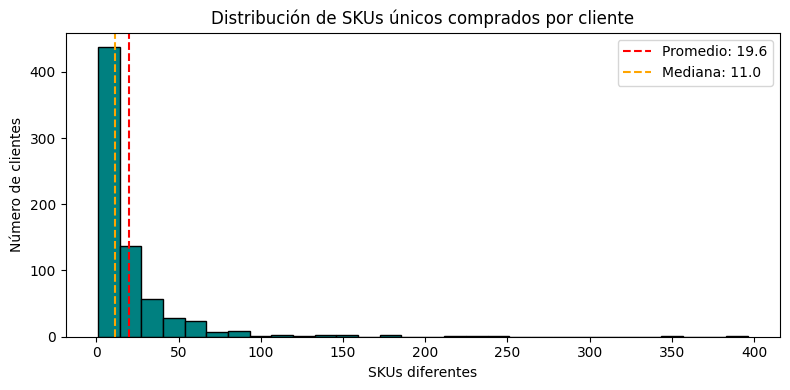

In [53]:
# Agrupar por cliente y contar SKUs únicos
productos_por_cliente = (
    df_ventas_items
    .groupby('cod_cliente')['cod_articulo_servicio']
    .nunique()
    .reset_index(name='productos_diferentes')
)

# Calcular estadísticos relevantes
promedio = productos_por_cliente['productos_diferentes'].mean()
mediana = productos_por_cliente['productos_diferentes'].median()
maximo = productos_por_cliente['productos_diferentes'].max()
minimo = productos_por_cliente['productos_diferentes'].min()

# Mostrar resumen
print(f"Promedio de SKUs diferentes por cliente: {promedio:.2f}")
print(f"Mediana: {mediana}")
print(f"Máximo: {maximo}")
print(f"Mínimo: {minimo}")

# Visualización opcional
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.hist(productos_por_cliente['productos_diferentes'], bins=30, color='teal', edgecolor='black')
plt.axvline(promedio, color='red', linestyle='--', label=f'Promedio: {promedio:.1f}')
plt.axvline(mediana, color='orange', linestyle='--', label=f'Mediana: {mediana}')
plt.title("Distribución de SKUs únicos comprados por cliente")
plt.xlabel("SKUs diferentes")
plt.ylabel("Número de clientes")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Agrupar compras por SKU
compras_por_sku = df_compras_items.groupby('cod_articulo_servicio')['cantidad'].sum().reset_index(name='cantidad_compras')

# Agrupar ventas por SKU
ventas_por_sku = df_ventas_items.groupby('cod_articulo_servicio')['cantidad'].sum().reset_index(name='cantidad_ventas')

# Unir ambos dataframes
movimiento = compras_por_sku.merge(ventas_por_sku, on='cod_articulo_servicio', how='left')

# Reemplazar NaNs en ventas con 0 (por si no hubo ventas de algún SKU)
movimiento['cantidad_ventas'] = movimiento['cantidad_ventas'].fillna(0)

# Calcular exceso de inventario
movimiento['exceso'] = movimiento['cantidad_compras'] - movimiento['cantidad_ventas']


In [54]:
# Mostrar las primeras filas de la tabla con exceso de inventario
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)  # Formato bonito

display(movimiento.head(10))  # Puedes cambiar el número de filas si lo deseas


,cod_articulo_servicio,cantidad_compras,cantidad_ventas,exceso
0,FLET,711.00,0.00,711.00
1,100001,41.00,16.00,25.00
2,100016,909.38,355.65,553.73
3,100017,295.50,128.23,167.27
4,100018,81.52,-1.54,83.06
5,100019,"15,160.49","9,179.34","5,981.15"
6,100022,"1,938.34","1,168.06",770.28
7,100023,"2,341.89","1,168.06","1,173.83"
8,100024,"9,744.00","4,323.70","5,420.30"
9,100026,52.06,21.60,30.46


In [ ]:
# Mostrar los top 5 productos con mayor exceso de inventario
top_exceso = movimiento.sort_values(by='exceso', ascending=False).head(5)
display(top_exceso)





,cod_articulo_servicio,cantidad_compras,cantidad_ventas,exceso
308,101039,"337,104.00","173,026.00","164,078.00"
315,101055,"300,648.00","152,796.00","147,852.00"
312,101052,"164,856.00","78,277.00","86,579.00"
1795,158998,"60,240.00",0.00,"60,240.00"
317,101057,"104,400.00","47,012.00","57,388.00"


KeyError: "None of [Index(['cod_articulo_servicio', 'nombre_articulo_servicio'], dtype='object')] are in the [columns]"

In [20]:
cliente_sku = df_ventas_items.groupby(['cod_articulo_servicio', 'cod_cliente'])['cantidad'].sum().reset_index()


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_2042/1062091899.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_candidatos, x='clientes_potenciales', y='cod_articulo_servicio', palette='crest')


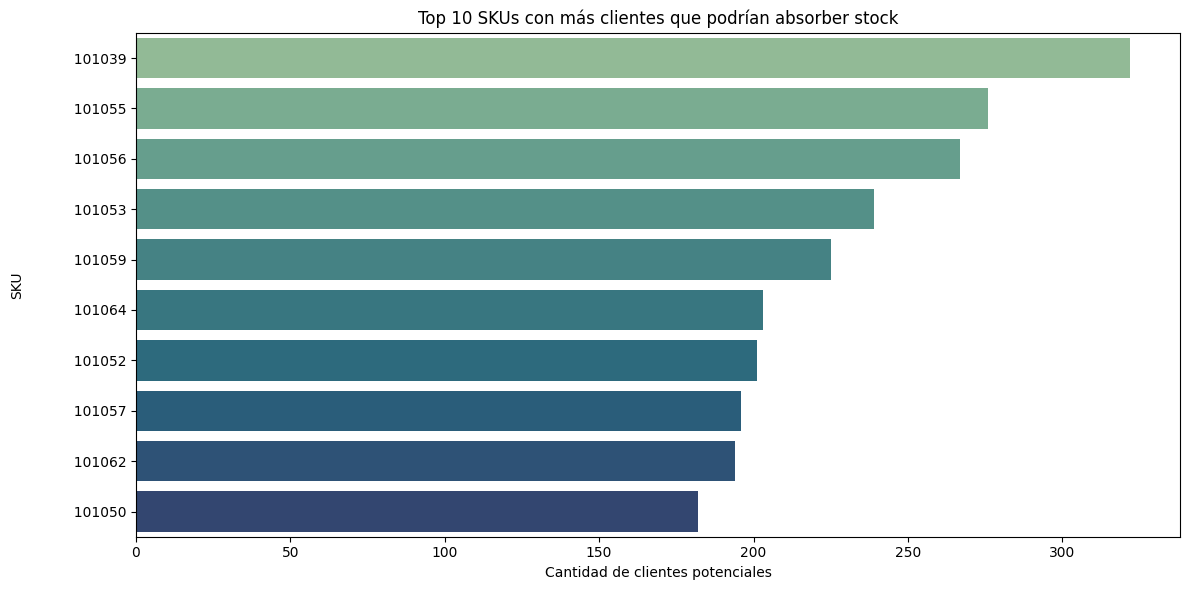

In [21]:
# Paso 1: Unir SKUs con exceso con los clientes que ya los han comprado
candidatos = movimiento[['cod_articulo_servicio', 'exceso']].merge(
    cliente_sku, on='cod_articulo_servicio', how='inner'
)

# Paso 2: Filtrar productos con exceso positivo
candidatos = candidatos[candidatos['exceso'] > 0]

# Paso 3: Agrupar por SKU y contar clientes únicos
top_candidatos = candidatos.groupby('cod_articulo_servicio')['cod_cliente'].nunique().reset_index(name='clientes_potenciales')

# Paso 4: Ordenar y tomar los 10 principales
top_candidatos = top_candidatos.sort_values('clientes_potenciales', ascending=False).head(10)

# Paso 5: Visualizar
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=top_candidatos, x='clientes_potenciales', y='cod_articulo_servicio', palette='crest')
plt.title("Top 10 SKUs con más clientes que podrían absorber stock")
plt.xlabel("Cantidad de clientes potenciales")
plt.ylabel("SKU")
plt.tight_layout()
plt.show()


In [22]:
# Número total de SKUs con exceso
kpi_skus_exceso = movimiento[movimiento['exceso'] > 0]['cod_articulo_servicio'].nunique()

# Número de clientes únicos que han comprado esos SKUs con exceso
clientes_exceso = candidatos['cod_cliente'].nunique()

# SKU con mayor exceso
sku_top_exceso = movimiento.sort_values('exceso', ascending=False).iloc[0]['cod_articulo_servicio']

# SKU con más clientes potenciales
sku_top_clientes = top_candidatos.iloc[0]['cod_articulo_servicio']

# Mostrar KPIs
print("SKUs con exceso de inventario:", kpi_skus_exceso)
print("Clientes potenciales únicos:", clientes_exceso)
print("Top SKU con más exceso:", sku_top_exceso)
print("Top SKU con más clientes potenciales:", sku_top_clientes)


SKUs con exceso de inventario: 1712
Clientes potenciales únicos: 641
Top SKU con más exceso:           101039
Top SKU con más clientes potenciales:           101039


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_2042/606847407.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_candidatos, x='clientes_potenciales', y='cod_articulo_servicio', palette='crest')


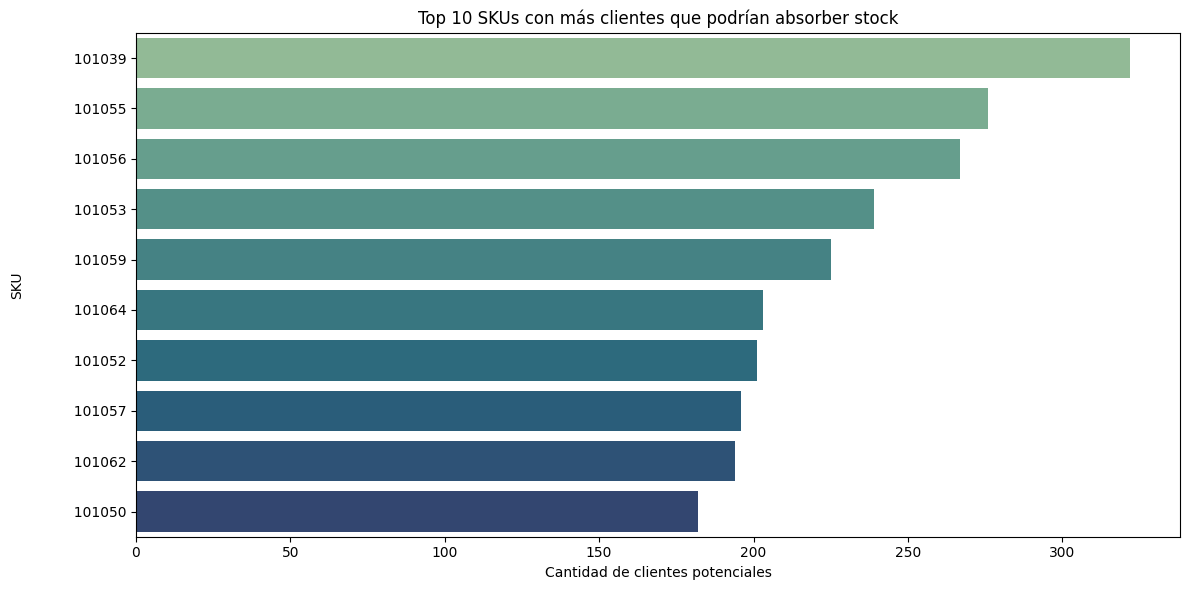

In [23]:
#Extraccion de clientes potenciales por SKU
# Paso 1: Clientes que han comprado por SKU
cliente_sku = df_ventas_items.groupby(['cod_articulo_servicio', 'cod_cliente'])['cantidad'].sum().reset_index()

# Paso 2: Unir con productos que tienen exceso de inventario (usa el dataframe `movimiento` si ya lo tienes)
# Asegúrate de que `movimiento` tenga las columnas: 'cod_articulo_servicio' y 'exceso'
candidatos = movimiento[['cod_articulo_servicio', 'exceso']].merge(cliente_sku, on='cod_articulo_servicio', how='inner')

# Paso 3: Filtrar productos que efectivamente tienen exceso
candidatos = candidatos[candidatos['exceso'] > 0]

# Paso 4: Agrupar por SKU y contar los clientes únicos
top_candidatos = candidatos.groupby('cod_articulo_servicio')['cod_cliente'].nunique().reset_index(name='clientes_potenciales')

# Paso 5: Ordenar y tomar los 10 principales
top_candidatos = top_candidatos.sort_values('clientes_potenciales', ascending=False).head(10)

# Paso 6: Visualizar
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=top_candidatos, x='clientes_potenciales', y='cod_articulo_servicio', palette='crest')
plt.title("Top 10 SKUs con más clientes que podrían absorber stock")
plt.xlabel("Cantidad de clientes potenciales")
plt.ylabel("SKU")
plt.tight_layout()
plt.show()


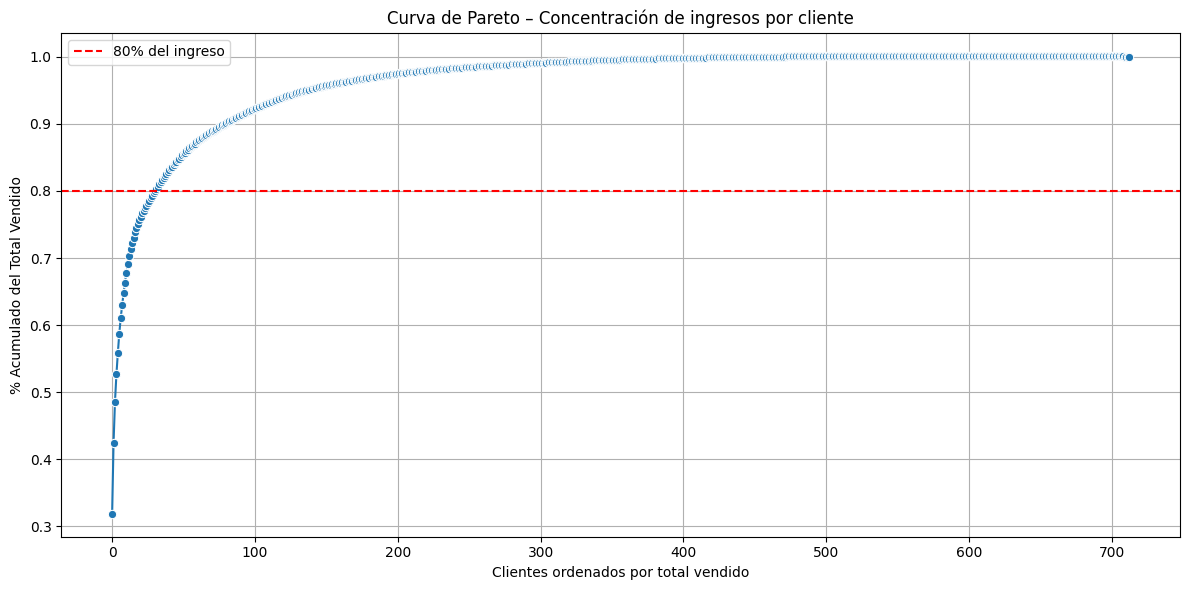

✅ El 80% del ingreso proviene de 31 clientes de un total de 713.


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_2042/1261371540.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_nombres, x='total_vendido', y='razon social', palette='Blues_r')


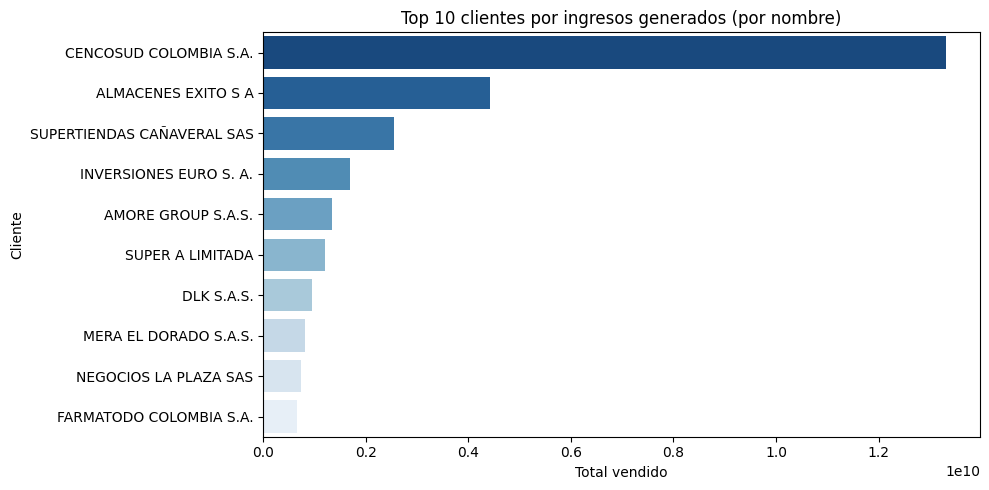

In [24]:
#Contentracion de ingresos por cliente y distribucion
#El objetivo se basa en identificar la minoria de clientes que generan la mayoria del ingreso
# ========================
# ANALISIS 1 - CONCENTRACION DE INGRESOS POR CLIENTE
# ========================

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Agrupar ventas por cliente y calcular total vendido
ventas_por_cliente = df_ventas_items.groupby('cod_cliente')[['subtotal']].sum().reset_index()
ventas_por_cliente.columns = ['cod_cliente', 'total_vendido']

# 2. Ordenar por monto total vendido (de mayor a menor)
ventas_por_cliente = ventas_por_cliente.sort_values('total_vendido', ascending=False)

# 3. Calcular porcentaje de contribución y porcentaje acumulado
ventas_por_cliente['porcentaje'] = ventas_por_cliente['total_vendido'] / ventas_por_cliente['total_vendido'].sum()
ventas_por_cliente['porcentaje_acumulado'] = ventas_por_cliente['porcentaje'].cumsum()

# 4. Enriquecer con nombre de cliente
df_enriquecido = ventas_por_cliente.merge(
    df_clientes[['codigo', 'razon social']],
    left_on='cod_cliente',
    right_on='codigo',
    how='left'
)

# 5. Curva de Pareto
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_enriquecido, x=df_enriquecido.index, y='porcentaje_acumulado', marker='o')
plt.axhline(0.8, color='red', linestyle='--', label='80% del ingreso')
plt.title('Curva de Pareto – Concentración de ingresos por cliente')
plt.xlabel('Clientes ordenados por total vendido')
plt.ylabel('% Acumulado del Total Vendido')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. ¿Cuántos clientes componen el 80% del ingreso?
clientes_top_80 = df_enriquecido[df_enriquecido['porcentaje_acumulado'] <= 0.80]
print(f"✅ El 80% del ingreso proviene de {len(clientes_top_80)} clientes de un total de {df_enriquecido.shape[0]}.")

# 7. Visualizar top 10 por nombre
top10_nombres = df_enriquecido.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(data=top10_nombres, x='total_vendido', y='razon social', palette='Blues_r')
plt.title('Top 10 clientes por ingresos generados (por nombre)')
plt.xlabel('Total vendido')
plt.ylabel('Cliente')
plt.tight_layout()
plt.show()


In [93]:
clientes_top_80 = df_enriquecido[df_enriquecido['porcentaje_acumulado'] <= 0.80]


In [94]:
print("Clientes que componen el 80% del ingreso:", clientes_top_80.shape[0])


Clientes que componen el 80% del ingreso: 31


In [95]:
# Confirmar el % acumulado del último cliente en el subconjunto
print("Último % acumulado en clientes_top_80:", clientes_top_80['porcentaje_acumulado'].max())


Último % acumulado en clientes_top_80: 0.7999602819438256


In [28]:
# Calcular los percentiles del ticket
percentiles = ticket_promedio['ticket_promedio'].quantile([0.2, 0.4, 0.6, 0.8, 1.0])
print(percentiles)



0.2    2.149746e+04
0.4    8.445789e+04
0.6    1.250549e+05
0.8    2.694721e+05
1.0    2.300000e+08
Name: ticket_promedio, dtype: float64


In [27]:
ticket_promedio = df_ventas_items.groupby('cod_cliente')[['subtotal']].mean().reset_index()
ticket_promedio.columns = ['cod_cliente', 'ticket_promedio']
ticket_promedio = ticket_promedio.merge(df_clientes[['codigo', 'razon social']], left_on='cod_cliente', right_on='codigo', how='left')



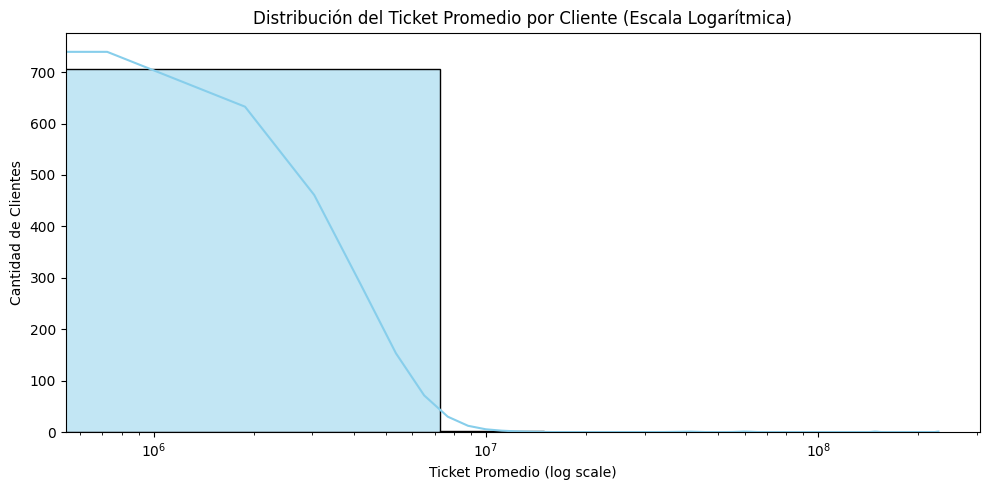

In [29]:
import numpy as np

plt.figure(figsize=(10, 5))
sns.histplot(ticket_promedio['ticket_promedio'], bins=30, kde=True, color='skyblue')
plt.xscale('log')
plt.title('Distribución del Ticket Promedio por Cliente (Escala Logarítmica)')
plt.xlabel('Ticket Promedio (log scale)')
plt.ylabel('Cantidad de Clientes')
plt.tight_layout()
plt.show()



In [30]:
!pip install faiss-cpu

import faiss
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Selecciona características relevantes para el clustering
features = ticket_promedio[['ticket_promedio']]  # Puedes añadir más columnas aquí
features = features.fillna(0)  # Manejo de nulos

# 2. Escalar los datos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 3. Convertir a float32 (FAISS lo requiere)
features_np = np.array(features_scaled).astype('float32')

# 4. Definir número de clusters (puedes ajustar este valor)
n_clusters = 5
kmeans = faiss.Kmeans(d=features_np.shape[1], k=n_clusters, niter=20, verbose=True)
kmeans.train(features_np)

# 5. Asignar cada cliente a un cluster
_, cluster_assignments = kmeans.index.search(features_np, 1)

# 6. Añadir al DataFrame original
ticket_promedio['cluster_faiss'] = cluster_assignments.flatten()



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Clustering 713 points in 1D to 5 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.02 s, search 0.02 s): objective=31.9038 imbalance=4.402 nsplit=0       


In [31]:
ticket_promedio['cluster_faiss'].value_counts().sort_index()


cluster_faiss
0     37
1      2
2    668
3      2
4      4
Name: count, dtype: int64

/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_2042/2315489743.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ticket_promedio, x='cluster_faiss', y='ticket_promedio', palette='Set2')


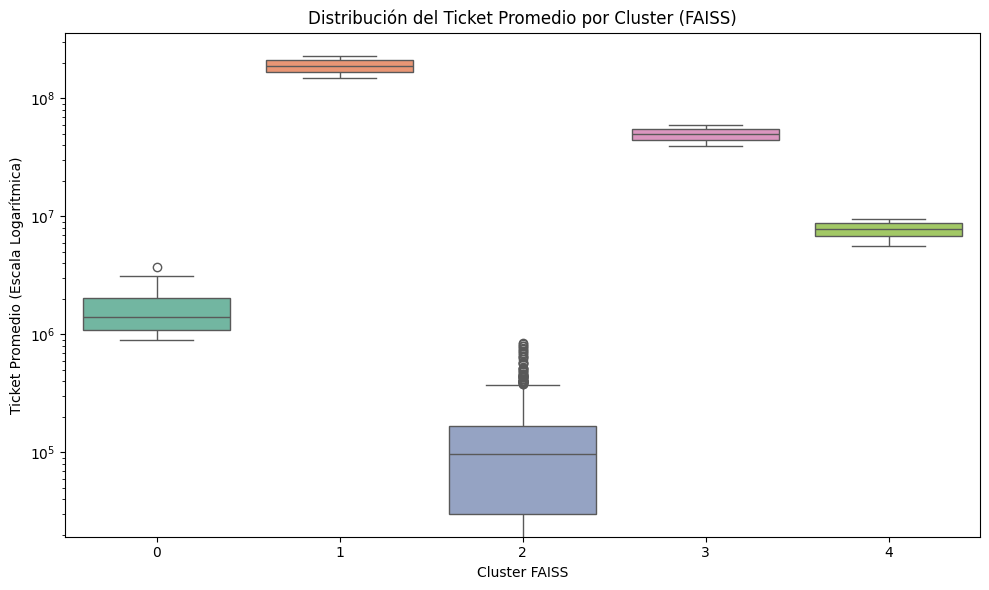

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=ticket_promedio, x='cluster_faiss', y='ticket_promedio', palette='Set2')
plt.yscale('log')
plt.title('Distribución del Ticket Promedio por Cluster (FAISS)')
plt.xlabel('Cluster FAISS')
plt.ylabel('Ticket Promedio (Escala Logarítmica)')
plt.tight_layout()
plt.show()


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=ticket_promedio,
    x='pca_1', y='pca_2',
    hue='cluster_faiss',
    palette='Set2',
    s=100,              # tamaño del punto
    alpha=0.8,
    edgecolor='black',
    linewidth=0.5
)

# Anotar algunos puntos con ticket más alto para dar contexto
top_clients = ticket_promedio.sort_values('ticket_promedio', ascending=False).head(5)
for _, row in top_clients.iterrows():
    plt.text(
        row['pca_1'] + 0.2,
        row['pca_2'],
        row['razon social'],
        fontsize=9,
        weight='bold',
        color='darkred'
    )

plt.title('🧠 Clusters FAISS de Clientes por Ticket Promedio (PCA)', fontsize=14)
plt.xlabel('🧩 Componente Principal 1')
plt.ylabel('🧩 Componente Principal 2')
plt.legend(title='Cluster FAISS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



ValueError: Could not interpret value `pca_1` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x700 with 0 Axes>

In [34]:
# Calcular métricas por cliente
metrics = df_ventas_items.groupby('cod_cliente').agg({
    'subtotal': ['sum', 'mean'],             # Volumen total y ticket promedio
    'documento': pd.Series.nunique,          # Frecuencia de compra (n° documentos únicos)
}).reset_index()

# Renombrar columnas
metrics.columns = ['cod_cliente', 'volumen_total', 'ticket_promedio', 'frecuencia_compra']



In [25]:
from sklearn.preprocessing import StandardScaler
import faiss
import numpy as np

# Escalar los datos
features = metrics[['ticket_promedio']]
features_scaled = StandardScaler().fit_transform(features)
features_np = np.array(features_scaled).astype('float32')

# Clustering con FAISS
n_clusters = 5
kmeans = faiss.Kmeans(d=features_np.shape[1], k=n_clusters, niter=20, verbose=True)
kmeans.train(features_np)
_, clusters = kmeans.index.search(features_np, 1)

# Asignar cluster al DataFrame
metrics['cluster_faiss'] = clusters.flatten()


Clustering 713 points in 1D to 5 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.00 s, search 0.00 s): objective=31.9038 imbalance=4.402 nsplit=0       


In [36]:
metrics = metrics.merge(df_clientes[['codigo', 'razon social']], left_on='cod_cliente', right_on='codigo', how='left')


In [37]:
tabla_cluster = metrics.groupby('cluster_faiss').agg({
    'ticket_promedio': 'mean',
    'volumen_total': 'sum',
    'frecuencia_compra': 'mean',
    'cod_cliente': 'count'
}).rename(columns={'cod_cliente': 'n_clientes'}).reset_index()


KeyError: 'cluster_faiss'

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar ticket promedio por cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=metrics, x='cluster_faiss', y='ticket_promedio', palette='Set2')
plt.yscale('log')
plt.title('Distribución de Ticket Promedio por Cluster (FAISS)')
plt.xlabel('Cluster FAISS')
plt.ylabel('Ticket Promedio (escala logarítmica)')
plt.tight_layout()
plt.show()


ValueError: Could not interpret value `cluster_faiss` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Escalamos volumen para usar como tamaño de burbuja
metrics['volumen_scaled'] = metrics['volumen_total'] / metrics['volumen_total'].max() * 1000

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=metrics,
    x='ticket_promedio',
    y='frecuencia_compra',
    size='volumen_scaled',
    hue='cluster_faiss',
    palette='Set2',
    sizes=(50, 2000),
    alpha=0.7,
    legend='brief'
)

# Anotar los nombres de clientes con volumen alto (p. ej. top 1%)
top_clientes = metrics[metrics['volumen_total'] > metrics['volumen_total'].quantile(0.99)]
for _, row in top_clientes.iterrows():
    plt.text(row['ticket_promedio'], row['frecuencia_compra'], row['razon social'], fontsize=9, weight='bold')

plt.title('Clientes Segmentados por Ticket Promedio y Frecuencia de Compra (FAISS)', fontsize=14)
plt.xlabel('Ticket Promedio por Cliente')
plt.ylabel('Frecuencia de Compra')
plt.legend(title='Cluster FAISS', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


ValueError: Could not interpret value `cluster_faiss` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1200x800 with 0 Axes>

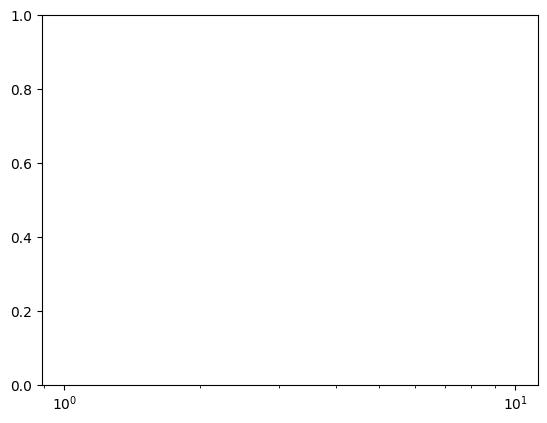

In [30]:
plt.xscale('log')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear gráfico con mejoras
plt.figure(figsize=(14, 9))
sns.scatterplot(
    data=metrics,
    x='ticket_promedio',
    y='frecuencia_compra',
    size='volumen_scaled',
    hue='cluster_faiss',
    palette='Set2',
    sizes=(40, 1200),
    edgecolor='black',
    alpha=0.6,
    legend='brief'
)

# Líneas de referencia (puedes ajustar según el negocio)
plt.axvline(x=1e6, color='gray', linestyle='--', alpha=0.4)
plt.axhline(y=500, color='gray', linestyle='--', alpha=0.4)

# Etiquetas para zonas estratégicas
plt.text(1e7, 1500, '🟩 VIP', fontsize=12, weight='bold', color='green')
plt.text(1e3, 1500, '🟦 Estrellas en crecimiento', fontsize=11, color='blue')
plt.text(1e7, 200, '🟧 Alta transacción\nBaja frecuencia', fontsize=11, color='orange')
plt.text(1e3, 200, '⬜ Dormidos', fontsize=11, color='gray')

# Anotar solo top volumen
top = metrics[metrics['volumen_total'] > metrics['volumen_total'].quantile(0.995)]
for _, row in top.iterrows():
    plt.annotate(
        row['razon social'],
        (row['ticket_promedio'], row['frecuencia_compra']),
        textcoords="offset points",
        xytext=(5, 5),
        ha='left',
        fontsize=9,
        weight='bold',
        bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6)
    )

# Escala log
plt.xscale('log')

# Estética
plt.title('Segmentación de Clientes: Ticket Promedio vs Frecuencia de Compra', fontsize=15)
plt.xlabel('Ticket Promedio por Cliente (escala logarítmica)', fontsize=12)
plt.ylabel('Frecuencia de Compra', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Segmento de Cliente', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




ValueError: Could not interpret value `cluster_faiss` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1400x900 with 0 Axes>

In [15]:
# Redondear numéricos a 2 decimales
perfil_clusters_redondeado = perfil_clusters.copy()

# Formatear las columnas económicas con símbolo de pesos y separador de miles
cols_monedas = ['ticket_promedio_medio', 'volumen_total', 'margen_promedio']
cols_decimales = ['frecuencia_promedio']

for col in cols_monedas:
    perfil_clusters_redondeado[col] = perfil_clusters_redondeado[col].apply(lambda x: f"${x:,.2f}")

for col in cols_decimales:
    perfil_clusters_redondeado[col] = perfil_clusters_redondeado[col].apply(lambda x: round(x, 2))

# Mostrar tabla limpia
from IPython.display import display
display(perfil_clusters_redondeado)



NameError: name 'perfil_clusters' is not defined

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear figura
plt.figure(figsize=(10, 6))

# Scatter con nueva paleta
scatter = plt.scatter(
    x=perfil_clusters['margen_promedio'],
    y=perfil_clusters['frecuencia_promedio'],
    c=perfil_clusters['volumen_total'],
    cmap='PuBuGn',
    s=400,
    edgecolor='black',
    linewidth=1.2
)

# Etiquetas del número de cluster al centro de cada burbuja
for _, row in perfil_clusters.iterrows():
    plt.text(row['margen_promedio'], row['frecuencia_promedio'],
             str(int(row['cluster_faiss'])),
             fontsize=10, weight='bold', ha='center', va='center', color='white')

# Barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Volumen Total Vendido', fontsize=11)

# Ejes y estilo
plt.xlabel('Margen Promedio', fontsize=12)
plt.ylabel('Frecuencia de Compra', fontsize=12)
plt.title('Matriz de Calor: Rentabilidad vs. Riesgo por Cluster FAISS', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



NameError: name 'perfil_clusters' is not defined

<Figure size 1000x600 with 0 Axes>

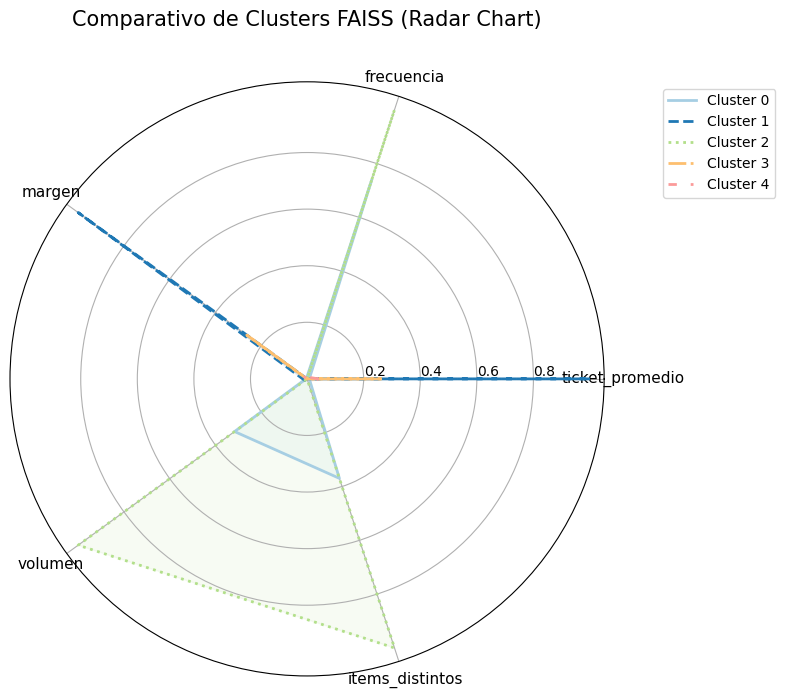

In [47]:
# Radar chart comparativo de los diferentes clusters

# 1. Calcular cantidad de ítems distintos por cliente
items_distintos = df_ventas_items.groupby('cod_cliente')['cod_articulo_servicio'] \
    .nunique().reset_index(name='items_distintos')

# 2. Eliminar columna si ya existe para evitar conflictos en el merge
if 'items_distintos' in ticket_promedio.columns:
    ticket_promedio = ticket_promedio.drop(columns=['items_distintos'])

# 3. Unir con ticket_promedio
ticket_promedio = ticket_promedio.merge(items_distintos, on='cod_cliente', how='left')

# 4. Agrupar por cluster FAISS para construir el perfil
perfil_clusters = ticket_promedio.groupby('cluster_faiss').agg(
    cod_cliente=('cod_cliente', 'nunique'),
    ticket_promedio=('ticket_promedio', 'mean'),
    frecuencia=('frecuencia_compra', 'mean'),
    margen=('margen', 'mean'),
    volumen=('volumen_total', 'sum'),
    items_distintos=('items_distintos', 'mean')
).reset_index()

# 5. Preparar para radar chart
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Selección de columnas
cols_radar = ['ticket_promedio', 'frecuencia', 'margen', 'volumen', 'items_distintos']

# Normalización
scaler = MinMaxScaler()
valores_norm = scaler.fit_transform(perfil_clusters[cols_radar])
df_norm = pd.DataFrame(valores_norm, columns=cols_radar)
df_norm['cluster_faiss'] = perfil_clusters['cluster_faiss']

# Preparar ángulos
labels = cols_radar
n_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, n_vars, endpoint=False).tolist()
angles += angles[:1]  # cerrar figura

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Colores diferenciados
colors = ['#A6CEE3', '#1F78B4', '#B2DF8A', '#FDBF6F', '#FB9A99']
estilos = ['solid', 'dashed', 'dotted', 'dashdot', (0, (3, 5, 1, 5))]

# Dibujar por cluster
for i, row in df_norm.iterrows():
    values = row[cols_radar].tolist()
    values += values[:1]  # cerrar figura
    ax.plot(angles, values, label=f"Cluster {int(row['cluster_faiss'])}", 
            color=colors[i], linestyle=estilos[i], linewidth=2)
    ax.fill(angles, values, color=colors[i], alpha=0.1)

# Estética
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], fontsize=10)
ax.set_title('Comparativo de Clusters FAISS (Radar Chart)', size=15, y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax.set_rlabel_position(0)
plt.tight_layout()
plt.show()




/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1237/1472169763.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/juanpardo/.pyenv/versions/3.10.14/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


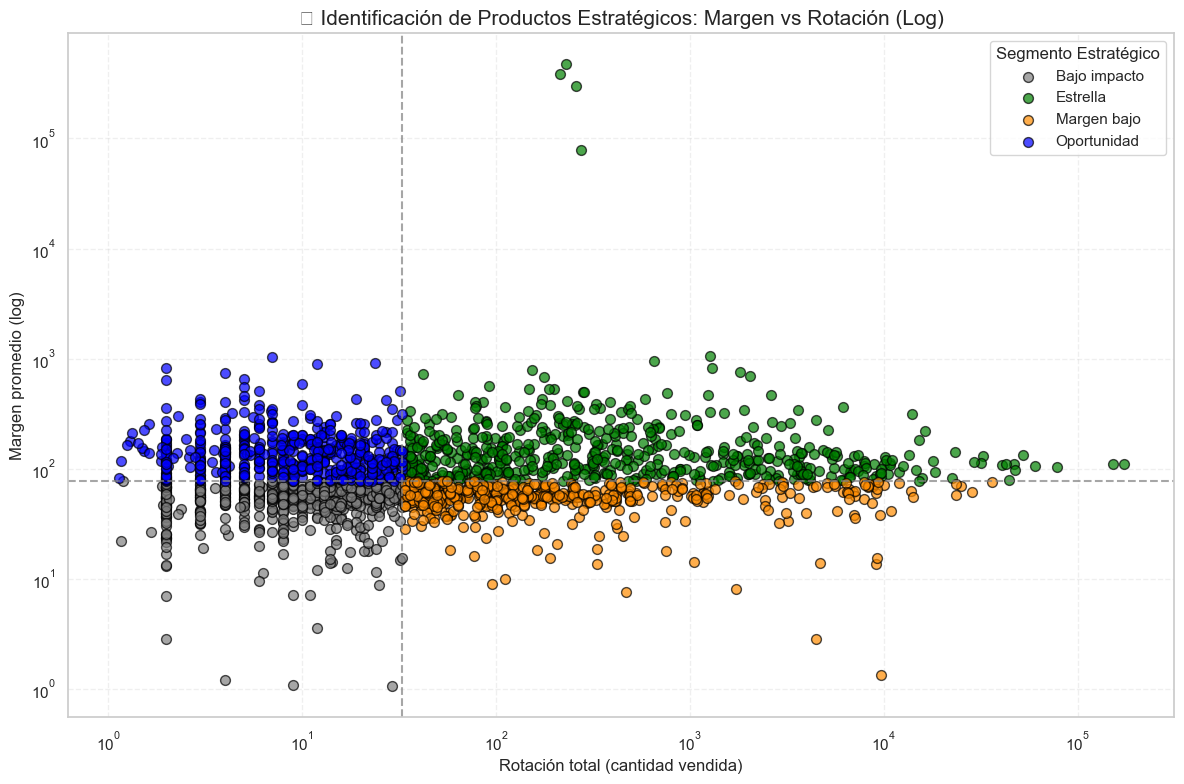

In [68]:
# Productos con alta rotación vs. alto margen
# 1. Filtrar datos positivos
productos = productos[(productos['rotacion_total'] > 1) & (productos['margen_promedio'] > 1)]

# 2. Referencias de corte
x_ref = productos['rotacion_total'].median()
y_ref = productos['margen_promedio'].median()

# 3. Clasificar por cuadrante
def clasificar_producto(row):
    if row['rotacion_total'] > x_ref and row['margen_promedio'] > y_ref:
        return 'Estrella'
    elif row['rotacion_total'] <= x_ref and row['margen_promedio'] > y_ref:
        return 'Oportunidad'
    elif row['rotacion_total'] <= x_ref and row['margen_promedio'] <= y_ref:
        return 'Bajo impacto'
    else:
        return 'Margen bajo'

productos['estrategia'] = productos.apply(clasificar_producto, axis=1)

# 4. Colores por estrategia
colores = {
    'Estrella': 'green',
    'Oportunidad': 'blue',
    'Margen bajo': 'darkorange',
    'Bajo impacto': 'gray'
}

# 5. Visualización
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.xscale('log')
plt.yscale('log')

for estrategia, grupo in productos.groupby('estrategia'):
    plt.scatter(
        grupo['rotacion_total'],
        grupo['margen_promedio'],
        label=estrategia,
        color=colores[estrategia],
        alpha=0.7,
        edgecolor='black',
        s=50
    )

# Líneas de referencia
plt.axvline(x=x_ref, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=y_ref, color='gray', linestyle='--', alpha=0.7)

# Etiquetas
plt.xlabel('Rotación total (cantidad vendida)', fontsize=12)
plt.ylabel('Margen promedio (log)', fontsize=12)
plt.title('📊 Identificación de Productos Estratégicos: Margen vs Rotación (Log)', fontsize=15)
plt.legend(title='Segmento Estratégico')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

   




/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1237/4239233582.py:73: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1237/4239233582.py:73: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1237/4239233582.py:73: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1237/4239233582.py:73: UserWarning: Glyph 129482 (\N{ICE CUBE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1237/4239233582.py:73: UserWarning: Glyph 9888 (\N{WARNING SIGN}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1237/4239233582.py:73: UserWarning: Glyph 65039 (\N{VARI

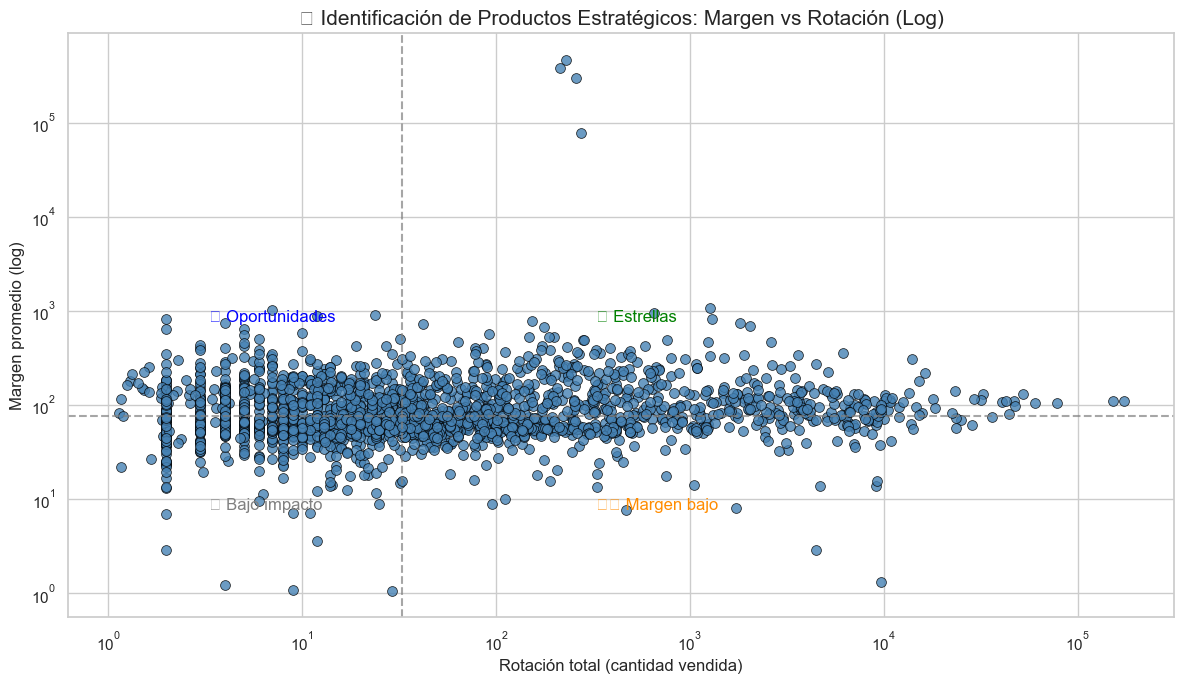

In [66]:
plot_productos_estrategicos(df_ventas_items)


In [69]:
# 1. Definir medianas como referencia de cuadrantes
x_ref = productos['rotacion_total'].median()
y_ref = productos['margen_promedio'].median()

# 2. Clasificar segmentos
productos['segmento'] = 'Otro'  # Inicializar columna

productos.loc[(productos['rotacion_total'] > x_ref) & (productos['margen_promedio'] > y_ref), 'segmento'] = 'Estrella'
productos.loc[(productos['rotacion_total'] > x_ref) & (productos['margen_promedio'] <= y_ref), 'segmento'] = 'Margen bajo'
productos.loc[(productos['rotacion_total'] <= x_ref) & (productos['margen_promedio'] > y_ref), 'segmento'] = 'Oportunidad'
productos.loc[(productos['rotacion_total'] <= x_ref) & (productos['margen_promedio'] <= y_ref), 'segmento'] = 'Bajo impacto'

# 3. Calcular participación del volumen total
productos['participacion'] = 100 * productos['rotacion_total'] / productos['rotacion_total'].sum()

# 4. Crear DataFrames filtrados
productos_estrella = productos[productos['segmento'] == 'Estrella'].sort_values(by='rotacion_total', ascending=False)
productos_margen_bajo = productos[productos['segmento'] == 'Margen bajo'].sort_values(by='rotacion_total', ascending=False)
productos_oportunidad = productos[productos['segmento'] == 'Oportunidad'].sort_values(by='rotacion_total', ascending=False)
productos_bajo_impacto = productos[productos['segmento'] == 'Bajo impacto'].sort_values(by='rotacion_total', ascending=False)

# 5. Mostrar tablas (puedes usar display si estás en Jupyter)
from IPython.display import display

print("🔰 Productos Estrella")
display(productos_estrella[['nombre', 'rotacion_total', 'margen_promedio', 'participacion']].head(10))

print("🟠 Productos con Margen Bajo")
display(productos_margen_bajo[['nombre', 'rotacion_total', 'margen_promedio', 'participacion']].head(10))

print("🔵 Productos Oportunidad")
display(productos_oportunidad[['nombre', 'rotacion_total', 'margen_promedio', 'participacion']].head(10))

print("⚫ Productos de Bajo Impacto")
display(productos_bajo_impacto[['nombre', 'rotacion_total', 'margen_promedio', 'participacion']].head(10))


🔰 Productos Estrella


,nombre,rotacion_total,margen_promedio,participacion
666,MERMEL 4 FRUTAS ST DALF X 284 GR,173026.0,110.125423,7.393787
673,MERMEL FRESA ST DALF X 284 GR,152796.0,111.236876,6.529314
670,MERMEL GROSELLA ST DALF X 284 GR,78277.0,104.920786,3.344951
674,MERMEL FRAMBUESA ST DALF X 284 GR,60419.0,106.124328,2.581839
2700,MINI BABYBEL X 6 X 120G,52178.0,132.725528,2.229682
696,MERMEL MINI CAJA X 4 UNID X 28 GR,47698.0,98.460669,2.038242
675,MERMEL NARANJA ST DALF X 284 GR,47012.0,110.955360,2.008928
2645,ILE DE FRANCE BRIE X 125 GR,44325.0,79.865730,1.894106
679,MERMEL DURAZNO ST DALF X 284 GR,42976.0,110.980246,1.836460
671,MERMEL AR¡NDANOS ( MORA SALVAJE ST DALF X 284...,40974.0,109.109727,1.750910


🟠 Productos con Margen Bajo


,nombre,rotacion_total,margen_promedio,participacion
2647,ILE DE FRANCE CAMEMBERT X 125 GR,36067.200,75.353879,1.541232
1121,FONDUE GRANDOR X 400 GR,28492.000,61.966062,1.217527
539,TOFU SILKEN EXTRA FIRM X 308 GR,25040.000,69.760399,1.070015
877,FUET EXTRA X160 GR,23602.000,57.692351,1.008566
557,TOFU FIRM X 307 GR,23517.000,73.402883,1.004934
2738,ARLA BRIE ROSENBOGR X 125 GR,14172.600,55.636419,0.605627
2240,FETA CHUNK EN SALMUERA X 226 G ODYSSEY,13857.000,62.495470,0.592141
1142,PARMESANO RUEDA GRAN SPICCO X KL,12043.065,73.967972,0.514627
735,FRESCO CAMPESINO X 3 KL APROX,10951.599,41.451642,0.467986
866,MAESE 3 MESES X 150 GRS,10089.000,71.028546,0.431125


🔵 Productos Oportunidad


,nombre,rotacion_total,margen_promedio,participacion
980,MOR. ACEITUNA NEGRA EN RODAJAS X 345,33.000,97.838933,0.001410
2661,ALM. CAPUCCINO BAILEYS,33.000,312.354292,0.001410
1936,GWS. MARQUES MERLOT 750,33.000,105.583967,0.001410
2023,ALM.CDV. ARROCAL PERRO GATO RATON 750,33.000,114.616194,0.001410
2171,GWS. WHISKY IWAI TRADITION 750,33.000,146.110774,0.001410
814,ROLLO DE CARNE X KL,32.825,136.588632,0.001403
2189,ALM. GWS. TRIVENTO GOLDEN RESERVA MALBEC 750,32.000,84.244464,0.001367
706,ALM. ADICION DE CARNES COCIDAS,32.000,505.008276,0.001367
1521,GWS. VINO ESPUMOSO CHANDON EXTRA BRUT 187,32.000,83.930423,0.001367
2006,ALM.CDV. RUTINI SYRAH,32.000,147.539967,0.001367


⚫ Productos de Bajo Impacto


,nombre,rotacion_total,margen_promedio,participacion
632,PORCION TORTA SEMILLAS DE AMAPOLA,33.0,45.370500,0.001410
1627,MG CHOCOTEJAS CAJA X 4 UND,33.0,15.459355,0.001410
765,DLK. ABADIA PAGO GARDU—A 750 ML,33.0,75.604833,0.001410
1224,CDV. LIVANA CABERNET FRANC-MALBEC X 750,33.0,56.725038,0.001410
2716,BOLSAS REGALO PARA VINO KRAFT,33.0,58.025321,0.001410
2672,INV. VINO BLANCO LIGHEA 750 ML,33.0,71.440043,0.001410
2641,MIEL DE ABEJAS X UND,33.0,77.175613,0.001410
1765,CDV. RUTINI SYRAH 750 ML,33.0,56.407786,0.001410
1785,INV. ARGENTO PINOT GRIGIO 750,33.0,51.115120,0.001410
575,INV. ALMA NEGRA BLANCO X 750,32.0,55.863290,0.001367


In [67]:
# Extraer productos estrella
productos_estrella = productos[
    (productos['rotacion_total'] > x_ref) &
    (productos['margen_promedio'] > y_ref)
].sort_values(by='rotacion_total', ascending=False).head(10)

# Agregar participación (opcional)
productos_estrella['participacion'] = (
    productos_estrella['rotacion_total'] / productos['rotacion_total'].sum()
) * 100

# Mostrar tabla
import pandas as pd
from IPython.display import display

display(productos_estrella[['nombre', 'rotacion_total', 'margen_promedio', 'participacion']])


,nombre,rotacion_total,margen_promedio,participacion
666,MERMEL 4 FRUTAS ST DALF X 284 GR,173026.0,110.125423,7.416307
673,MERMEL FRESA ST DALF X 284 GR,152796.0,111.236876,6.549201
670,MERMEL GROSELLA ST DALF X 284 GR,78277.0,104.920786,3.355139
674,MERMEL FRAMBUESA ST DALF X 284 GR,60419.0,106.124328,2.589703
2700,MINI BABYBEL X 6 X 120G,52178.0,132.725528,2.236474
696,MERMEL MINI CAJA X 4 UNID X 28 GR,47698.0,98.460669,2.044450
675,MERMEL NARANJA ST DALF X 284 GR,47012.0,110.955360,2.015047
2645,ILE DE FRANCE BRIE X 125 GR,44325.0,79.865730,1.899875
679,MERMEL DURAZNO ST DALF X 284 GR,42976.0,110.980246,1.842054
671,MERMEL AR¡NDANOS ( MORA SALVAJE ST DALF X 284...,40974.0,109.109727,1.756243


/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1237/1967108362.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  etiquetas = clientes.groupby('segmento').apply(lambda g: g.sort_values('frecuencia_compra', ascending=False).head(1)).reset_index(drop=True)


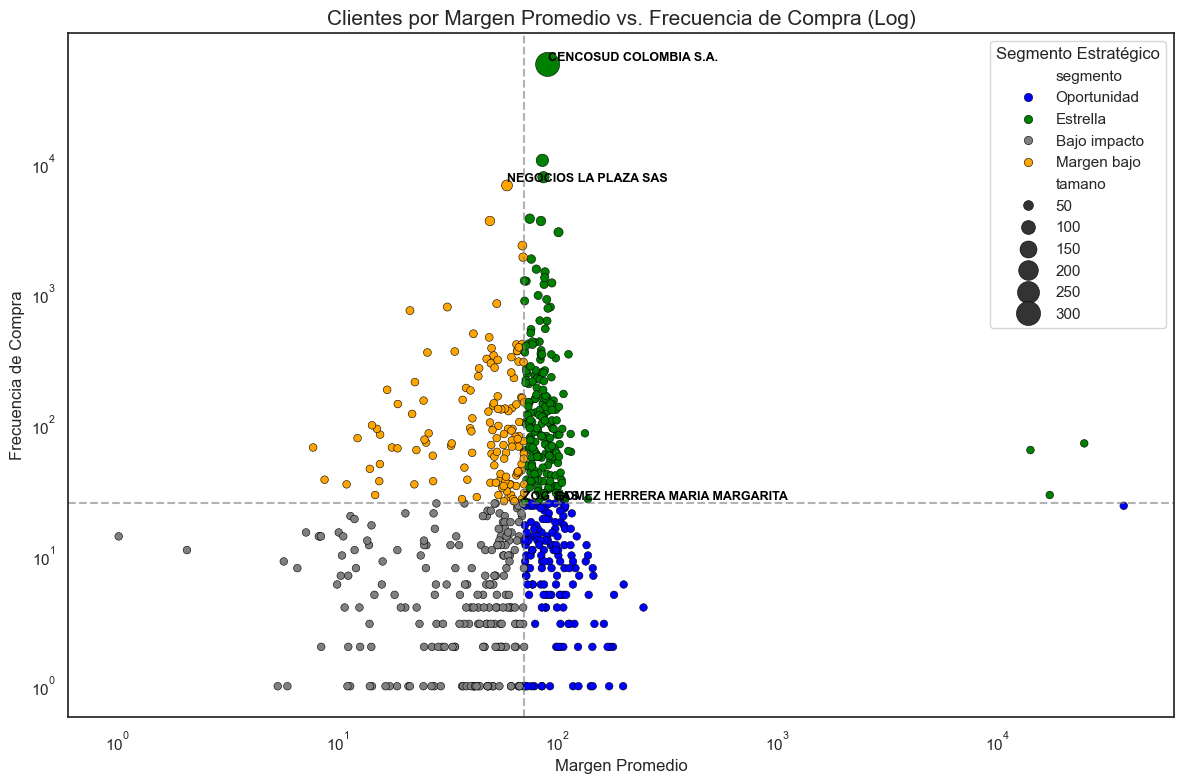

In [73]:
#Heatmap por cliente: Margen vs. frecuencia
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1. Calcular referencias
x_ref = clientes['margen_promedio'].median()
y_ref = clientes['frecuencia_compra'].median()

# 2. Clasificación
def clasificar_cliente(row):
    if row['margen_promedio'] > x_ref and row['frecuencia_compra'] > y_ref:
        return 'Estrella'
    elif row['margen_promedio'] <= x_ref and row['frecuencia_compra'] > y_ref:
        return 'Margen bajo'
    elif row['margen_promedio'] > x_ref and row['frecuencia_compra'] <= y_ref:
        return 'Oportunidad'
    else:
        return 'Bajo impacto'

clientes['segmento'] = clientes.apply(clasificar_cliente, axis=1)

# 3. Etiquetas (ejemplo: top cliente por segmento)
etiquetas = clientes.groupby('segmento').apply(lambda g: g.sort_values('frecuencia_compra', ascending=False).head(1)).reset_index(drop=True)

# 4. Normalizar tamaño
scaler = MinMaxScaler((30, 300))
clientes['tamano'] = scaler.fit_transform(clientes[['frecuencia_compra']])

# 5. Paleta de colores
palette = {
    'Estrella': 'green',
    'Margen bajo': 'orange',
    'Oportunidad': 'blue',
    'Bajo impacto': 'gray'
}

# 6. Gráfico
plt.figure(figsize=(12, 8))
sns.set(style='white')

scatter = sns.scatterplot(
    data=clientes,
    x='margen_promedio',
    y='frecuencia_compra',
    hue='segmento',
    palette=palette,
    size='tamano',
    sizes=(30, 300),
    legend='brief',
    edgecolor='black',
    linewidth=0.4
)

# Líneas de referencia
plt.axvline(x=x_ref, color='gray', linestyle='--', alpha=0.6)
plt.axhline(y=y_ref, color='gray', linestyle='--', alpha=0.6)

# Escalas logarítmicas
plt.xscale('log')
plt.yscale('log')

# Etiquetar los top clientes por segmento
for _, row in etiquetas.iterrows():
    plt.text(
        row['margen_promedio'], row['frecuencia_compra'],
        row['nombre_cliente'],
        fontsize=9, weight='bold', color='black',
        ha='left', va='bottom'
    )

# Ajustes finales
plt.title('Clientes por Margen Promedio vs. Frecuencia de Compra (Log)', fontsize=15)
plt.xlabel('Margen Promedio', fontsize=12)
plt.ylabel('Frecuencia de Compra', fontsize=12)
plt.tight_layout()
plt.legend(title='Segmento Estratégico')
plt.show()






In [97]:
# Frecuencia de compra = número de registros por cliente
frecuencia_por_cliente = df_ventas_items['cod_cliente'].value_counts().reset_index()
frecuencia_por_cliente.columns = ['cod_cliente', 'frecuencia_compra']



In [98]:
umbral_frecuencia = frecuencia_por_cliente['frecuencia_compra'].median()


In [99]:
# Filtrar clientes con frecuencia por encima del umbral
alta_frecuencia = frecuencia_por_cliente[frecuencia_por_cliente['frecuencia_compra'] > umbral_frecuencia]

# Volumen total y volumen en clientes de alta frecuencia
volumen_total = frecuencia_por_cliente['frecuencia_compra'].sum()
volumen_alta = alta_frecuencia['frecuencia_compra'].sum()

# Porcentaje
porcentaje_alta_frecuencia = volumen_alta / volumen_total * 100
print(f"{porcentaje_alta_frecuencia:.1f}% del volumen proviene de clientes de alta frecuencia")


97.8% del volumen proviene de clientes de alta frecuencia


In [74]:
# ⭐ Estrellas
clientes_estrella = clientes[clientes['segmento'] == 'Estrella'].sort_values(by='frecuencia_compra', ascending=False)

# 🔵 Oportunidades
clientes_oportunidad = clientes[clientes['segmento'] == 'Oportunidad'].sort_values(by='margen_promedio', ascending=False)

# 🟠 Margen Bajo
clientes_margen_bajo = clientes[clientes['segmento'] == 'Margen bajo'].sort_values(by='frecuencia_compra', ascending=False)

# ⚫ Bajo Impacto
clientes_bajo_impacto = clientes[clientes['segmento'] == 'Bajo impacto'].sort_values(by='frecuencia_compra', ascending=False)

# Mostrar (puedes ajustar a top 10 si prefieres)
import plotly.express as px
import pandas as pd
from IPython.display import display

display(clientes_estrella[['nombre_cliente', 'margen_promedio', 'frecuencia_compra']].head(10))
display(clientes_oportunidad[['nombre_cliente', 'margen_promedio', 'frecuencia_compra']].head(10))
display(clientes_margen_bajo[['nombre_cliente', 'margen_promedio', 'frecuencia_compra']].head(10))
display(clientes_bajo_impacto[['nombre_cliente', 'margen_promedio', 'frecuencia_compra']].head(10))


,nombre_cliente,margen_promedio,frecuencia_compra
98,CENCOSUD COLOMBIA S.A.,90.318265,57026
183,SUPERTIENDAS CA—AVERAL SAS,85.485681,10522
32,INVERSIONES EURO S. A.,86.452218,7820
16,SUPER A LIMITADA,74.901832,3765
213,LAURELES S.A.S,84.233185,3617
1,ALMACENES EXITO S A,101.197747,2968
30,CLUB DEL VINO LTDA,76.097112,1850
51,LA RESERVA VINOS Y LICORES S.A.S.,80.236651,1549
118,INVERSIONES ZONAZUL S.A.S,87.876176,1476
209,ADWELLCH S.A.S.,87.585195,1334


,nombre_cliente,margen_promedio,frecuencia_compra
696,CONSORCIO NACIONAL DE MEDIOS SAS,37595.152958,24
711,EVOLUTION TECHNOLOGIES GROUP SAS,246.394750,4
710,EVOLUTION OUTSOURCING S.A.S,200.310667,6
602,AMEZQUITA BUITRAGO MIREYA CONSUELO,199.015000,1
680,RAMON BERNAL Y CIA SAS,180.985000,5
4,COMERCIALIZADORA DE ALIMENTOS GOURMENT LTDA,179.028000,2
603,ROMERO BEJARANO JUAN NICOLAS,173.668000,2
635,CARVAJAL GARCIA MARIA ESPERANZA,171.991000,1
664,PAULA HARKER SAS,169.284000,2
600,MANOPLA ARABI ALBERTO ABUD,162.775000,3


,nombre_cliente,margen_promedio,frecuencia_compra
111,NEGOCIOS LA PLAZA SAS,59.022573,6769
24,DLK S.A.S.,49.368368,3619
416,BEB SAS,69.369996,2345
270,INVERSIONES Y REPRESENTACIONES SAN RAFAEL S.A.S,69.915345,1912
675,KINTSUGI EMPRESARIAL S.A.S,53.033438,844
662,AMORE GROUP S.A.S.,31.602699,795
31,ALZATE ARISTIZABAL ALBA LUCERO,21.368600,747
224,FIDEICOMISO G H BOGOTA - FIDUBOGOTA,41.532378,497
361,HOTELES ESTELAR S.A.,48.979609,466
185,MERA EL DORADO S.A.S.,69.184957,414


,nombre_cliente,margen_promedio,frecuencia_compra
571,ZOG SAS,69.927040,25
61,VARGAS TORO JAIME FELIPE,37.800760,25
663,RICARDO SIERRA,51.833480,25
264,MORA QUINTERO ANTONIO JOSE,28.186880,25
395,INVERSIONES BIOSOSTENIBLES SAS,68.228200,25
201,ESCADA FINANCIAL CORP SUCURSAL COLOMBIA,52.420320,25
22,CLUB COLOMBIA,69.721080,25
340,LENIS MELO JOHNNATHAN,65.663040,25
449,DI SAURO RAFFAELLO,66.357750,24
36,INVERSIONES PICCOLO CAFFE S A S,65.582826,23


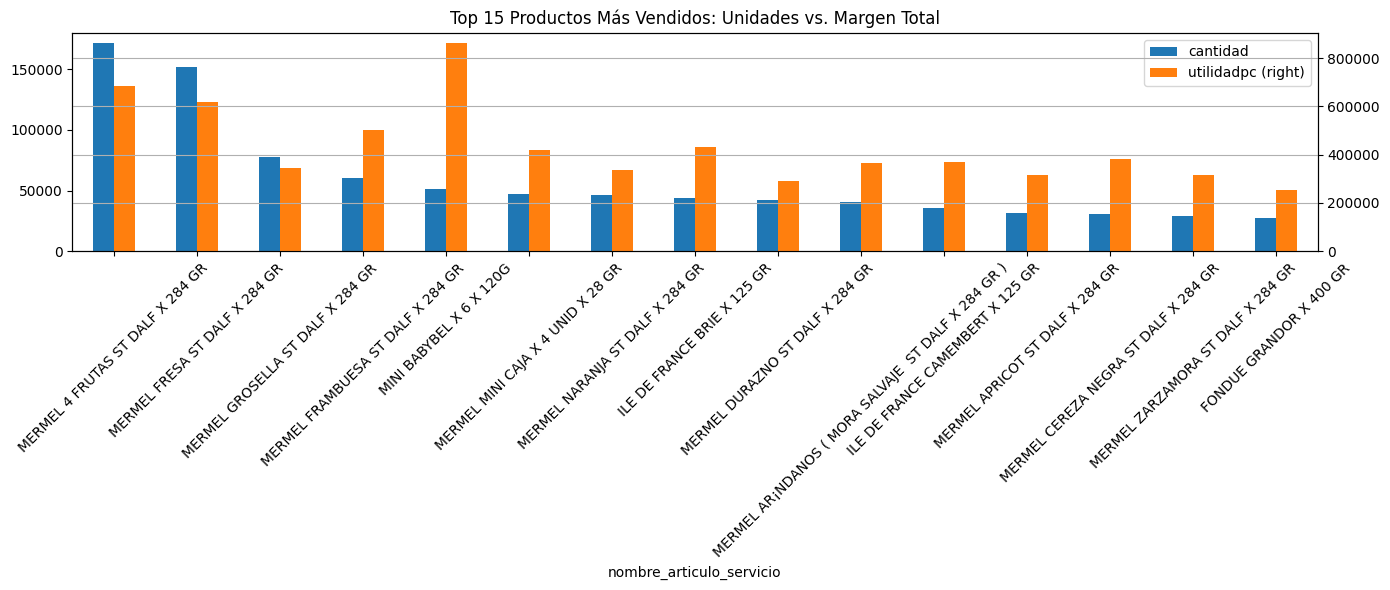

In [55]:
#Gráfico de barras: Productos más vendidos por unidades vs. margen total
# Agregar por producto
productos_bar = df_ventas_items.groupby('nombre_articulo_servicio').agg({
    'cantidad': 'sum',
    'utilidadpc': 'sum'
}).sort_values(by='cantidad', ascending=False).head(15)

# Graficar
productos_bar.plot(kind='bar', figsize=(14, 6), secondary_y='utilidadpc', rot=45)
plt.title('Top 15 Productos Más Vendidos: Unidades vs. Margen Total')
plt.xlabel('Producto')
plt.grid(True)
plt.tight_layout()
plt.show()


In [109]:
# Agrupar por producto
productos = df_ventas_items.groupby('nombre_articulo_servicio').agg({
    'cantidad': 'sum',
    'utilidadpc': 'sum'
}).reset_index()

# Ordenar por volumen (cantidad)
productos_top15 = productos.sort_values(by='cantidad', ascending=False).head(15)

# Calcular contribución al total
volumen_total = productos['cantidad'].sum()
margen_total = productos['utilidadpc'].sum()

volumen_top15 = productos_top15['cantidad'].sum()
margen_top15 = productos_top15['utilidadpc'].sum()

# Mostrar resultados
print(f"Top 15 productos representan:")
print(f"- {volumen_top15 / volumen_total * 100:.1f}% del volumen total")
print(f"- {margen_top15 / margen_total * 100:.1f}% del margen total")


Top 15 productos representan:
- 38.2% del volumen total
- 2.8% del margen total


In [6]:
# Relación clientes – ventas
df_compras_enriquecido = df_compras_items.merge(
    df_articulos, 
    how='left', 
    left_on='cod_articulo_servicio', 
    right_on='codigo'
)

print("Vista previa - Compras enriquecidas con artículos:")
print(df_compras_enriquecido[['cod_articulo_servicio', 'nombre', 'cantidad', 'subtotal']].head())




Vista previa - Compras enriquecidas con artículos:
  cod_articulo_servicio                                          nombre  \
0                100481       LC. RIESLING EVIDENCE GUSTAVE LORENTZ 750   
1                100483  LC. VINO NARANJA QUI´L EUT CRU GUSTAVE LORENTZ   
2                100616     LC. PINOT NOIR PAYS DOC PASCAL BOUCHARD 750   
3                100485     LC. CHARDONNAY PASCAL BOUCHARD CLEOPHAS 750   
4                121858                    INV. CATENA CHARDONNAY X 750   

   cantidad  subtotal  
0       1.0  100526.0  
1       2.0  192980.0  
2       4.0  264000.0  
3      12.0  792000.0  
4       1.0   65780.0  


In [7]:
#Relacion de articulos -ventas (items)
df_ventas_enriquecido = df_ventas_items.merge(
    df_articulos, 
    how='left', 
    left_on='cod_articulo_servicio', 
    right_on='codigo'
)

print("Vista previa - Ventas enriquecidas con artículos:")
print(df_ventas_enriquecido[['cod_articulo_servicio', 'nombre', 'cantidad', 'subtotal']].head())


Vista previa - Ventas enriquecidas con artículos:
  cod_articulo_servicio                               nombre  cantidad  \
0                101050  MERMEL PIÑA /MANGO ST DALF X 284 GR      12.0   
1                101096    MERMEL MINI CAJA X 4 UNID X 28 GR       6.0   
2                121623         GRANA PADANO X 200 G ZANETTI      12.0   
3                150174          ILE DE FRANCE BRIE X 125 GR      12.0   
4                150179     ILE DE FRANCE CAMEMBERT X 125 GR       6.0   

   subtotal  
0  193200.0  
1   79200.0  
2  238800.0  
3  199200.0  
4   95400.0  


Con el objetivo de lograr analisis mas estrategicos y segmentaciones comerciales inteligentes, es fundamental contar con informacion adicional del cliente en cada transaccion

El bloque de codigo a continuacion se encarga de realizar lo siguiente 
1. Realiza un "merge" entre el dataframe de ventas y el dataframe de clientes
2. Usa como clave de union el campo "cod_cliente"
3. Agrega columnas relevantes como "razon social" y "pais" al dataset de ventas
4. Muestra una vista previa 

Esto sirve para los siguientes objetivos: 
1. Permite tener una trazabilidad de cada venta hasta el cliente responsable
2. Habilita analisis por pais, razon social o segmento del cliente
3. Es un paso fundamental para validar hipotesis como: Patrones de recompra, concentracion por cliente o potencial de absorcion de inventario

In [8]:
#Relacion clientes-ventas 
df_ventas_enriquecido = df_ventas_enriquecido.merge(
    df_clientes.rename(columns={'codigo': 'cod_cliente'}),
    how='left',
    on='cod_cliente'
)

print("Vista previa - Ventas enriquecidas con clientes:")
print(df_ventas_enriquecido[['cod_cliente', 'razon social', 'pais', 'subtotal']].head())


Vista previa - Ventas enriquecidas con clientes:
        cod_cliente     razon social           pais  subtotal
0  CL  100000001136  ADWELLCH S.A.S.  CO - COLOMBIA  193200.0
1  CL  100000001136  ADWELLCH S.A.S.  CO - COLOMBIA   79200.0
2  CL  100000001136  ADWELLCH S.A.S.  CO - COLOMBIA  238800.0
3  CL  100000001136  ADWELLCH S.A.S.  CO - COLOMBIA  199200.0
4  CL  100000001136  ADWELLCH S.A.S.  CO - COLOMBIA   95400.0


In [9]:
#Presentacion de merge recomendados 
#Dataframes enriquecidos que muestran la informacion de los articulos, clientes, compras y ventas
# Artículos + ventas
df_ventas_enriquecido = df_ventas_items.merge(df_articulos, left_on='cod_articulo_servicio', right_on='codigo', how='left')

# Agregar clientes
df_clientes_renamed = df_clientes.rename(columns={'codigo': 'cod_cliente'})
df_ventas_enriquecido = df_ventas_enriquecido.merge(df_clientes_renamed, on='cod_cliente', how='left')

# Compras + artículos
df_compras_enriquecido = df_compras_items.merge(df_articulos, left_on='cod_articulo_servicio', right_on='codigo', how='left')


In [16]:
#Validacion de la hipotesis para el Modulo 1: Funcionamiento del inventario inteligente
#Hipotesis: Existen productos con rotacion baja o nula presentando un posible riesgo de sobrestock
# ===========================================================
# Validación de la hipótesis para el Módulo 1:
# Funcionamiento del inventario inteligente
# ===========================================================
# Hipótesis: Existen productos con rotación baja o nula,
# lo cual presenta un posible riesgo de sobrestock.
# ===========================================================

# 1. Agrupar ventas por SKU
ventas_por_sku = df_ventas_enriquecido.groupby('cod_articulo_servicio')['cantidad'].sum().reset_index()

# 2. Agrupar compras por SKU
compras_por_sku = df_compras_enriquecido.groupby('cod_articulo_servicio')['cantidad'].sum().reset_index()

# 3. Fusionar ambas tablas
movimiento = compras_por_sku.merge(
    ventas_por_sku,
    on='cod_articulo_servicio',
    how='left',
    suffixes=('_compras', '_ventas')
)

# 4. Rellenar valores nulos en ventas (por si no hubo ventas para un SKU)
movimiento['cantidad_ventas'] = movimiento['cantidad_ventas'].fillna(0)

# 5. Calcular exceso de inventario (compras - ventas)
movimiento['exceso'] = movimiento['cantidad_compras'] - movimiento['cantidad_ventas']

# 6. Enriquecer con nombre de producto desde el catálogo
movimiento = movimiento.merge(
    df_articulos[['codigo', 'nombre']],
    left_on='cod_articulo_servicio',
    right_on='codigo',
    how='left'
)

# 7. Verificación rápida
movimiento[['cod_articulo_servicio', 'nombre', 'cantidad_compras', 'cantidad_ventas', 'exceso']].head()



,cod_articulo_servicio,nombre,cantidad_compras,cantidad_ventas,exceso
0,FLET,FLETE (FAC CIF),711.00,0.000,711.000
1,100001,CI. CANASTO CINTA PLAST DISEÑO S,41.00,16.000,25.000
2,100016,KOL. JAMON DE POLLO AHUMADO,909.38,355.653,553.727
3,100017,KOL. JAMONADA ESPECIAL,295.50,128.229,167.271
4,100018,KOL. JAMON DE RES,81.52,-1.538,83.058


Explicación de la validacion de la hipotesis para el módulo 1: Funcionamiento del inventario inteligente 
Hipotesis: Existen productos con rotacion baja o nula, lo cual representa un posible riesgo de sobrestock

Objetivo: 
1. Verificar si existen diferencias significativas entre la cantidad de productos comprados vs la cantidad de productos vendidos por SKU, identificando los articulos con una acumulacion de inventario sin rotacion. 

Proceso Aplicado: 

1. Agrupacion de compras y ventas totales por SKU. 
2. Fusión de ambas tablas para comparar comportamientos por producto. 
3. Calculo del campo "Exceso" = Compras-Ventas
4. Identificacion de SKUS con "Cantidad_ventas" baja o igual a cero. 
5. Enriquecimiento con el nombre del producto para la mejor comprensión. 

Resultados Generados: 

La hipotesis queda "validada" dado que se han identificado multiples prouctos donde ocurre lo siguiente: 

1. Las ventas presentadas son nulas o muy bajas. 
2. Las compras presentadas son considerablemente superiores. 
3. Esto genera acumulacion de stock (riesgo de sobrestock) afectando directamente la rentabilidad operacional. 

Se confirma entonces que con la creación del agente de inteligencia artificial pensado para Premium Choice, efectivamente es factible que se pueda construir el módulo de inventario inteligente que podrá utilizar esta lógica para detectar automáticamente productos en riesgo de estancamiento, permitiendo generar alertas tempranas, optimización de compras y sugerencias de liquidación o activación comercial. 





Text(0.5, 1.0, 'Productos en posible sobrestock')

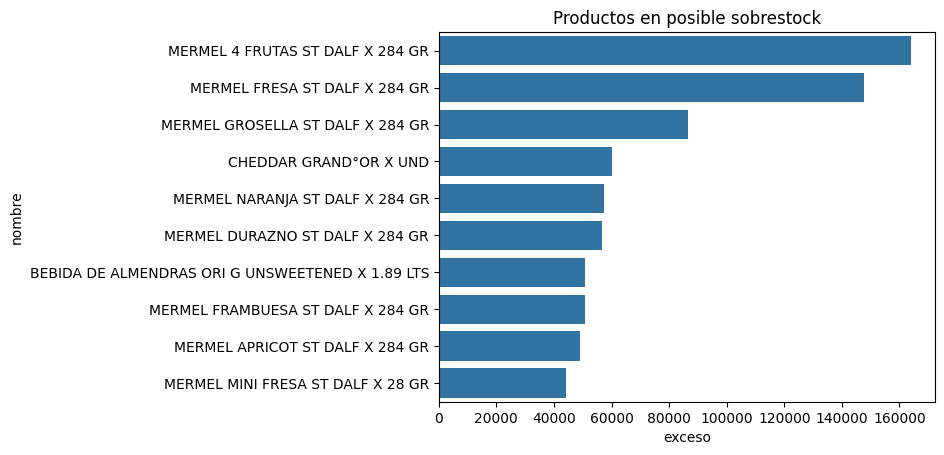

In [ ]:
#Productos que presentan los mayores niveles del exceso de inventario
#Importacion de las bibliotecas necesarias para la visualizacion y para el analisis.
import seaborn as sns
import matplotlib.pyplot as plt


#Top 10 de los productos presentados con un mayor nivel de exceso del inventario
# Top 10 productos con más exceso
top_exceso = movimiento.sort_values('exceso', ascending=False).head(10)
sns.barplot(data=top_exceso, x='exceso', y='nombre')
plt.title("Productos en posible sobrestock")


El grafico comprueba las necesidades asociadas con la hipotesis 1 del modlo del inventario inteligente, donde efectivamente existen productos con rotacion baja o nula que presentan un posible riesgo de sobrestock. Este grafico muestra los 10 productos con mayor exceso de inventarios, lo cual valida la hipotesis y demuestra la relevancia de implementar un modulo de inventario inteligente. Claramente se identifican los productos con un mayor nivel de diferencia entre compras-ventas representando el potencial de sobrestock.

Este analisis se encarga de combinar las cantidades compradas y vendidas por SKU a lo largo del tiempo y el histórico para el calculo del exceso del inventario acumulado. A partir de ello, es posible identificar aquellos productos que presentan los mayores niveles de diferencia entre las compras y las ventas, lo cual representa el potencial sobrestock en bodega.



/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1789/2595719457.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dispersion_ordenado, x='cod_articulo_servicio', y='std_participacion', palette='coolwarm')


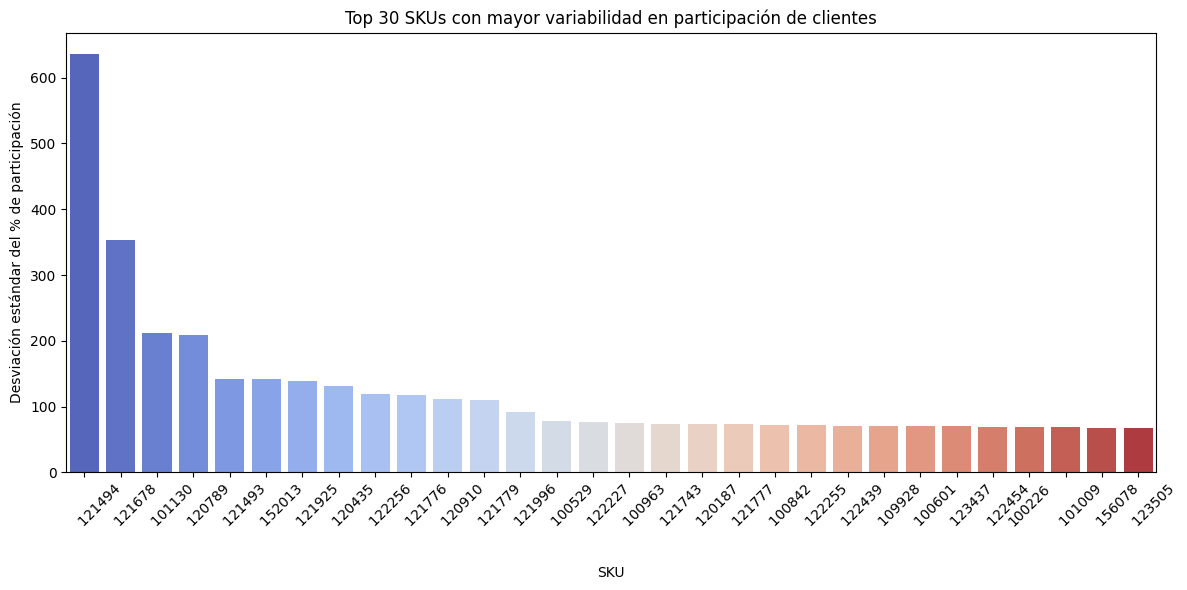

In [ ]:
#Presentacion de los SKUs que representan el mayor nivel de variabilidad en participacion de los clientes 
#Validacion de la hiptesis del modulo 2: Predicción de rotacion por SKU y por Canal.
dispersion = rotacion_por_cliente.groupby('cod_articulo_servicio')['porcentaje'].std().reset_index(name='std_participacion')
import seaborn as sns
import matplotlib.pyplot as plt

# Ordenar por desviación para mejorar lectura
dispersion_ordenado = dispersion.sort_values(by='std_participacion', ascending=False).head(30)

plt.figure(figsize=(12, 6))
sns.barplot(data=dispersion_ordenado, x='cod_articulo_servicio', y='std_participacion', palette='coolwarm')

plt.title('Top 30 SKUs con mayor variabilidad en participación de clientes')
plt.xlabel('SKU')
plt.ylabel('Desviación estándar del % de participación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Text(0.5, 0, 'Desviación estándar de % participación')

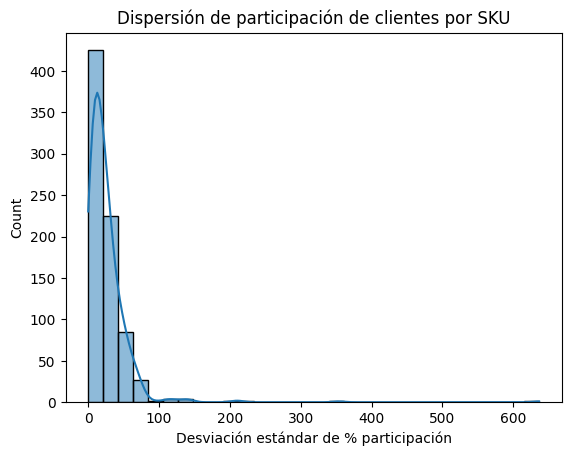

In [24]:
# =============================================
# Validación de hipótesis para el Módulo 2
# Predicción de rotación por SKU y canal
# =============================================

# Hipótesis:
# La rotación varía significativamente por cliente o canal,
# por lo cual es predecible.

# Calcular concentración por SKU con std de porcentaje
dispersión = rotacion_por_cliente.groupby('cod_articulo_servicio')['porcentaje'].std().reset_index(name='std_participacion')

# Visualizar distribución de dispersión
sns.histplot(dispersión['std_participacion'], bins=30, kde=True)
plt.title('Dispersión de participación de clientes por SKU')
plt.xlabel('Desviación estándar de % participación')




Interpretacion Tecnica del Grafico presentado: 

1. Eje X: Se encarga de mostrar los rangos de desviacion estandar (%) de participacion de clientes para un SKU. 
    Ejemplo: "Si una barra está en 0-10, significa que muchos SKUs tienen muy poca variacion en como compran sus distintos clientes. 
                Además, si esta en un 100+, significa que algunos de los clientes compran casi todo el inventario de ese SKU y los demás poco o nada. 

2. Eje Y: Representa la cantidad de SKUs que tienen este nivel de dispersión. 
        Ejemplo: "La primera barra (a la izquierda) indica cuantos SKUs tienen una desviacion muy baja (es decir, una participacion muy equilibrada entre clientes)
                Las siguientes muestran cuantas tienen una participacion desigual, es decir mas concentrada."

¿Que nos esta diciendo entonces el grafico? 

1. Que la mayoria de los SKUs presentados cuentan con una alta dispersion en la participacion de los clientes. 

Esto valida que la rotacion varia segun el cliente o el canal, dado que no existe uniformidad en el consumo de productos entre todos los clientes, es por esto que la hipotesis del modulo 2 se valida con datos estadisticos. 

Validacion de la hipotesis del modulo 2: Predicción de Rotacion por SKU y Canal 

Hipotesis: "La rotacion varia significativamente por cliente o canal, por lo cual es predecible"

Evidencia: Se analizo la distribución del porcentaje de participación de cada cliente para cada SKU

Se calculo la desviacion estandar del 1% de participacion de clientes por SKU, lo cual permite medir la concentracion do dispersion en el consumo de cada uno de los productos. 

Identificacion del resultado: 

1. Existen patrones de consumo distintos por cada cliente o canal. 
2. La rotacion presentada es dependiente del cliente, lo que la hace una rotacion "predecible"
3. Es posible entrenar un modelo que condicione el agente de inteligencia artificial que se encargue de proyectar la rotacion por canal. 

La hipotesis presentada queda validada con evidencia cuantitativa. 


In [14]:
#Validation de hipotesis para el Modulo 3: Agente comercial automatizado 
#Hipotesis: Algunos clientes podrian absorber el inventario excedente si se identifican por patrones historicos de compra
# Clientes con mayores compras por SKU
cliente_sku = df_ventas_enriquecido.groupby(['cod_articulo_servicio', 'cod_cliente'])['cantidad'].sum().reset_index()

# Fusionar con productos en exceso
candidatos = movimiento[['cod_articulo_servicio', 'exceso']].merge(cliente_sku, on='cod_articulo_servicio')

# Filtrar donde exceso > 0 y cliente ha comprado
candidatos = candidatos[candidatos['exceso'] > 0]


In [22]:
rotacion_por_cliente['cod_articulo_servicio'] = rotacion_por_cliente['cod_articulo_servicio'].astype(str)



/var/folders/fl/4p9gdc5d3wj63rppd6xjpnmh0000gn/T/ipykernel_1789/97780740.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_candidatos, x='clientes_potenciales', y='cod_articulo_servicio', palette='crest')


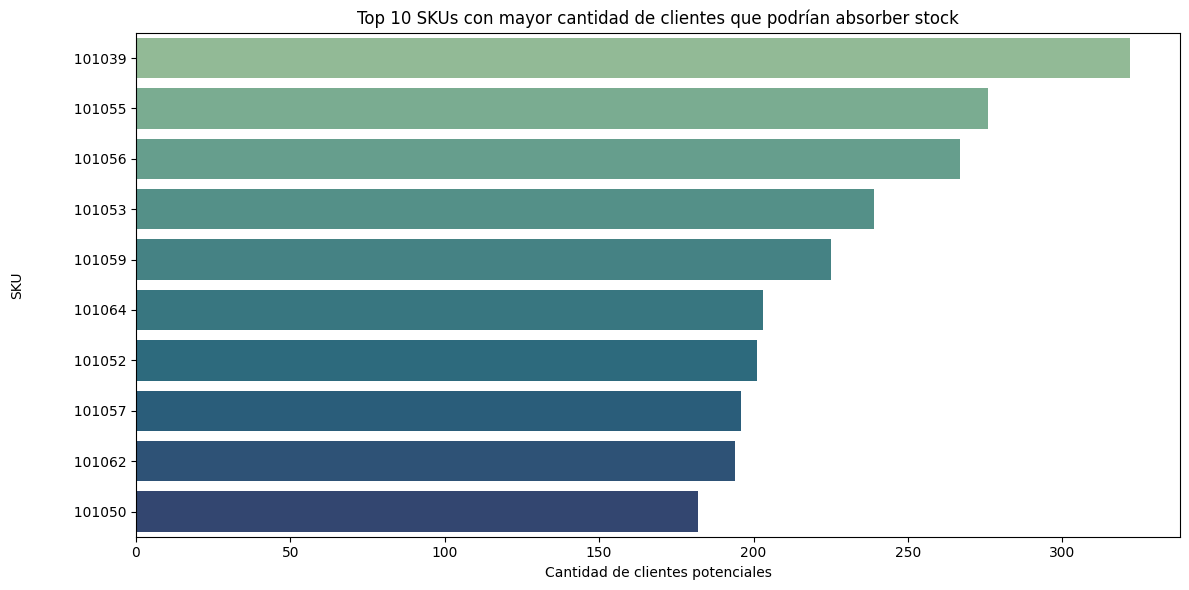

In [29]:
#Clientes potenciales para absorver el inventario excedente (stock)
# Top SKU con más clientes potenciales para absorber stock
# Importar librerías necesarias
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Agrupar clientes potenciales por SKU (clientes que ya compraron ese SKU con exceso)
top_candidatos = candidatos.groupby('cod_articulo_servicio').size().reset_index(name='clientes_potenciales')

# 2. Ordenar y seleccionar los 10 principales
top_candidatos = top_candidatos.sort_values('clientes_potenciales', ascending=False).head(10)

# 3. Visualizar
plt.figure(figsize=(12, 6))
sns.barplot(data=top_candidatos, x='clientes_potenciales', y='cod_articulo_servicio', palette='crest')
plt.title("Top 10 SKUs con mayor cantidad de clientes que podrían absorber stock")
plt.xlabel("Cantidad de clientes potenciales")
plt.ylabel("SKU")
plt.tight_layout()
plt.show()



El analisis a continuacion busca profundizar en la validacion de la hipotesis de que existen clientes historicos con el potencial de absorber el inventario excedente. Si se logra activar una acción comercial estratégica.

Para esto fue posible lograr los siguientes elementos: 

1. Se agrupan los candidatos (clientes que han comprado previamente un SKU con sobrestock)
2. Se calcula la cantidad total comprada por SKU por parte de estos candidatos. 
3. Se ordenan los SKUs con mayor volumen total de compras por estos clientes. 

Que revela la tabla del codigo? 
1. Los 10 SKUs listados que han sido comprados en grandes cantidades por clientes que ya han demostrado interes previo. 
2. Estos volumenes reflejan una alta probabilidad de recompra por lo que representan oportunidades claras para redistribuir el inventario en exceso. 
3. Es una forma adicional de reforzar la hipotesis: no solo hay muchos clientes posibles, sino que ademas compran mucho 

In [32]:
# Agrupar por SKU y cliente, sumar cantidad comprada
candidatos_sum = candidatos.groupby(['cod_articulo_servicio', 'cod_cliente'])['cantidad'].sum().reset_index(name='cantidad_compras')

# Agrupar por SKU y sumar total de compras de candidatos
top_skus_candidatos = candidatos_sum.groupby('cod_articulo_servicio')['cantidad_compras'].sum().reset_index()

# Ordenar y seleccionar top 10
top_skus_candidatos = top_skus_candidatos.sort_values('cantidad_compras', ascending=False).head(10)

top_skus_candidatos


,cod_articulo_servicio,cantidad_compras
103,101039,171539.0
110,101055,151423.0
107,101052,77678.0
111,101056,59277.0
112,101057,46143.0
687,159005,45629.0
116,101062,42358.0
662,150174,40937.0
108,101053,40312.0
664,150179,33178.0


El codigo a continuacion se encarga de mostrar lo siguiente: 
1. Que tan relevante es el grupo de candidatos dentro del universo total de compradores del SKU. 
2.El análisis evidencia una alta relevancia del grupo de candidatos: Todos los SKUs listados cuentan con una proporcion completa, es decir que todos los clientes estan considerados como candidatos dado que son compradores demostrados y tambien compradores activos.
3. Se puede entonces comprobar que existen productos en exceso con grupos de clientes identificables, relevantes y comprometidos, lo que permite implementar un agente comercial automatizado con alta efectividad. 

In [31]:
#Proporion de candidatos vs el total de clientes que han comprado el SKU
total_clientes = df_ventas_enriquecido.groupby('cod_articulo_servicio')['cod_cliente'].nunique().reset_index(name='total_clientes')
candidatos_clientes = candidatos.groupby('cod_articulo_servicio')['cod_cliente'].nunique().reset_index(name='clientes_candidatos')

proporcion = candidatos_clientes.merge(total_clientes, on='cod_articulo_servicio')
proporcion['porcentaje_candidatos'] = (proporcion['clientes_candidatos'] / proporcion['total_clientes']) * 100
proporcion.sort_values('porcentaje_candidatos', ascending=False).head(10)


,cod_articulo_servicio,clientes_candidatos,total_clientes,porcentaje_candidatos
0,100016,8,8,100.0
489,122376,49,49,100.0
469,122245,20,20,100.0
470,122246,22,22,100.0
471,122247,26,26,100.0
472,122248,34,34,100.0
473,122249,23,23,100.0
474,122250,24,24,100.0
475,122251,17,17,100.0
476,122252,28,28,100.0


Basado en el grafico, es posible asegurarnos que se evidencian multiples SKUs con varios clientes compradores historicos, lo que demuestra que hay oportundiades reales de redistribuir el stock excedente a estos clientes a medida que se realize una accion comercial automatizada (de la manera en que lo haria el agente IA)

Es importante informar que en este caso, un candidato se refiere al cliente que ya compró en el pasado un SKU que actualmente presenta exceso de inventario, es decir que cuenta con los siguientes puntos: 

1. Tiene un historial de compras reales con ese producto. 
2. Ese producto mencionado cuenta con un exceso de inventario

In [3]:
%whos


Interactive namespace is empty.


In [5]:
#Extraccion de clientes principales por SKU 
# Paso 1: Clientes que han comprado por SKU
cliente_sku = df_ventas_items.groupby(['cod_articulo_servicio', 'cod_cliente'])['cantidad'].sum().reset_index()

# Paso 2: Unir con productos que tienen exceso de inventario (usa el dataframe `movimiento` si ya lo tienes)
# Asegúrate de que `movimiento` tenga las columnas: 'cod_articulo_servicio' y 'exceso'
candidatos = movimiento[['cod_articulo_servicio', 'exceso']].merge(cliente_sku, on='cod_articulo_servicio', how='inner')

# Paso 3: Filtrar productos que efectivamente tienen exceso
candidatos = candidatos[candidatos['exceso'] > 0]

# Paso 4: Agrupar por SKU y contar los clientes únicos
top_candidatos = candidatos.groupby('cod_articulo_servicio')['cod_cliente'].nunique().reset_index(name='clientes_potenciales')

# Paso 5: Ordenar y tomar los 10 principales
top_candidatos = top_candidatos.sort_values('clientes_potenciales', ascending=False).head(10)

# Paso 6: Visualizar
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=top_candidatos, x='clientes_potenciales', y='cod_articulo_servicio', palette='crest')
plt.title("Top 10 SKUs con más clientes que podrían absorber stock")
plt.xlabel("Cantidad de clientes potenciales")
plt.ylabel("SKU")
plt.tight_layout()
plt.show()



NameError: name 'df_ventas_items' is not defined